In [1]:
from bin.experimental_pipeline import DeciferPipeline
from bin.train import TrainConfig
from glob import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm
from pymatgen.core import Structure
from pymatgen.core import Structure as PMGStructure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.groups import SpaceGroup
from ase.visualize.plot import plot_atoms
from ase.data import colors, atomic_numbers

from decifer.utility import (
    pxrd_from_cif,
    extract_formula_nonreduced,
    extract_space_group_symbol,
)
from typing import Optional, Union, Tuple
from matplotlib.patches import Circle, Patch


In [2]:
def plot_unit_cell_with_boundaries(
    structure: Structure,
    ax: Optional[plt.Axes] = None,
    tol: float = 1e-5,
    radii: float = 0.8,
    rotation: Union[str, Tuple[str, ...]] = ('45x, -15y, 90z'),
    offset: Tuple[float, float, float] = (0, 0, 0)
) -> Tuple[plt.Axes, PMGStructure]:
    """
    Plots the unit cell with periodic boundaries using ASE and pymatgen.

    Parameters:
        structure (Structure): The pymatgen Structure to plot.
        ax (Optional[plt.Axes]): Matplotlib axes to plot on. If None, a new figure and axes are created.
        tol (float): Tolerance for duplicate fractional coordinates.
        radii (float): Radius for the atoms in the plot.
        rotation (Union[str, Tuple[str, ...]]): Rotation applied to the structure.
        offset (Tuple[float, float, float]): Offset applied to the structure.

    Returns:
        Tuple[plt.Axes, PMGStructure]: The axes and the discrete structure created for plotting.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Define translation vectors for periodic images
    translation_vectors = [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]

    all_species: List[str] = []
    all_coords: List[np.ndarray] = []

    # Loop over each translation vector to create periodic images
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # Only add sites that satisfy the fractional coordinate condition
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)

    # Create a discrete structure using pymatgen
    discrete_structure = PMGStructure(
        lattice=structure.lattice.matrix,
        species=all_species,
        coords=np.array(all_coords),
        coords_are_cartesian=True
    )

    # Convert the structure to ASE atoms and disable periodic boundary conditions for plotting
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)

    return ax, discrete_structure

def preprocess_data(folder, q_min_crop=0.0, q_max_crop=10.0, base_fwhm=0.01, size_estimate=1000, debug_max=None):
    """
    Processes all .pkl files in the given folder and returns a dictionary with the best results.
    """
    files = sorted(glob(os.path.join(folder, "*.pkl")))
    best = {}
    total_files = min(len(files), debug_max) if debug_max else len(files)
    pbar = tqdm(total=total_files, desc="Processing files...", leave=False, dynamic_ncols=True)
    
    for file in files[:debug_max]:
        name = os.path.basename(file).split(".")[0]
        best[name] = {}
        with open(file, "rb") as f:
            data_loaded = pickle.load(f)
        results = data_loaded.get("results", None)
        exp_q = data_loaded.get("exp_q", None)
        exp_i = data_loaded.get("exp_i", None)
        raw_q = data_loaded.get("raw_q", None)
        raw_i = data_loaded.get("raw_i", None)
        # prep_config is loaded but not used further
        _ = data_loaded.get("prep_config", None)
    
        best_result = None
        best_rwp = float("inf")
        best_pxrd = None
    
        pbar_best = tqdm(total=len(results["gens"]), desc='Finding best structure...', leave=False, dynamic_ncols=True)
        for res in results["gens"]:
            pxrd = pxrd_from_cif(res["cif_str"], base_fwhm=base_fwhm, particle_size=size_estimate)
            q_std = exp_q[(exp_q >= q_min_crop) & (exp_q <= q_max_crop)]
            i_std = exp_i[(exp_q >= q_min_crop) & (exp_q <= q_max_crop)]
            i_pred_interpolated = np.interp(q_std, pxrd["q"], pxrd["iq"])
            rwp = np.sqrt(np.sum((i_std - i_pred_interpolated)**2) / np.sum(i_std**2))
            if rwp < best_rwp:
                best_rwp = rwp
                best_result = res
                best_pxrd = pxrd 
            pbar_best.update(1)
        pbar_best.close()
    
        best[name]["result"] = best_result
        best[name]["pxrd"] = best_pxrd
        best[name]["exp_q"] = exp_q
        best[name]["exp_i"] = exp_i
        best[name]["raw_q"] = raw_q
        best[name]["raw_i"] = raw_i
    
        pbar.update(1)
    pbar.close()
    return best

def save_preprocessed_data(data, save_path):
    """
    Saves the preprocessed data dictionary to a file.
    """
    with open(save_path, "wb") as f:
        pickle.dump(data, f)

def load_preprocessed_data(load_path):
    """
    Loads the preprocessed data dictionary from a file.
    """
    with open(load_path, "rb") as f:
        return pickle.load(f)

def plot_data(best, plot_params=None):
    """
    Plots the experimental and predicted data along with structure insets.
    """
    # Default plotting parameters
    if plot_params is None:
        plot_params = {
            "figsize": (12, 12),
            "c_pred": "C3",
            "c_pred_cont": "C2",
            "pred_marker_size": 3.0,
            "atom_radii": 0.5,
            "atom_tol": 1e-5,
            "atom_offset": (0, 0, 0),
            "atom_rotation": ('45x, -15y, 90z'),
            "atom_legend_radius": 1.2,
            "struc_offset_x": 0.25,
            "struc_offset_y": 0.5,
            "struc_scale_width": 1.0,
            "struc_scale_height": 0.1,
            "struc_axis_off": True,
            "struc_add_axis_x": 10.0,
            "struc_add_axis_y": 5.0,
            "show_estimate": False,
        }
    
    fig, ax = plt.subplots(figsize=plot_params["figsize"])
    
    for i, (key, val) in enumerate(best.items()):
        result = val['result']
        ax.plot(val['exp_q'], val['exp_i'] - 1.5 * i, lw=1, c='k')
        stem = ax.stem(np.array(val['pxrd']["q_disc"][0]),
                       np.array(val['pxrd']["iq_disc"][0]) / 100 - 1.5 * i, 
                       bottom=-1.5 * i,
                       linefmt=f'{plot_params["c_pred"]}-',
                       markerfmt=f'{plot_params["c_pred"]}o',
                       basefmt=' ')
        stem.markerline.set(markersize=plot_params["pred_marker_size"],
                            markerfacecolor='white',
                            markeredgecolor=plot_params["c_pred"],
                            markeredgewidth=1.0)
        stem.markerline.set_xdata(np.array(val['pxrd']["q_disc"][0]))

        if plot_params["show_estimate"]:
            ax.plot(val['pxrd']["q"], val['pxrd']["iq"] - 1.5*i, label='Estimated', color=plot_params["c_pred_cont"], ls='-', lw=1)
    
        # Create an inset axes for the structure plot
        ax_struc = ax.inset_axes([plot_params["struc_offset_x"],
                                  0.85 - i / (len(best) / 0.9),
                                  plot_params["struc_scale_width"],
                                  plot_params["struc_scale_height"]])
        pos = ax.get_position()
        ax_struc.set_position([pos.x0 + plot_params["struc_offset_x"],
                               pos.y0 + plot_params["struc_offset_y"],
                               pos.width * plot_params["struc_scale_width"],
                               pos.height * plot_params["struc_scale_height"]])
        plot_unit_cell_with_boundaries(result["struct"],
                                       ax=ax_struc,
                                       radii=plot_params["atom_radii"],
                                       rotation=plot_params["atom_rotation"],
                                       offset=plot_params["atom_offset"],
                                       tol=plot_params["atom_tol"])
        max_coord = result["struct"].cart_coords.max()
    
        ax_struc.set_ylim(-plot_params["struc_add_axis_y"], max_coord * 3)
        ax_struc.set_xlim(-plot_params["struc_add_axis_x"], max_coord + plot_params["struc_add_axis_x"])
        if plot_params["struc_axis_off"]:
            ax_struc.axis('off')
    
        # Create legend for the atomic species in the structure plot
        unique_species = sorted(set([site.species_string for site in result["struct"]]))
        n_species = len(unique_species)
        legend_y = ax_struc.get_ylim()[0] + 2.0
        x_positions = np.linspace(max_coord - n_species * plot_params["atom_legend_radius"] - plot_params["atom_legend_radius"],
                                  max_coord - plot_params["atom_legend_radius"],
                                  n_species)
    
        for x, species in zip(x_positions, unique_species):
            try:
                atom_color = colors.jmol_colors[atomic_numbers[species]]
            except KeyError:
                atom_color = 'black'
            circ = Circle((x, legend_y),
                          radius=plot_params["atom_legend_radius"],
                          edgecolor='black',
                          facecolor=atom_color,
                          lw=1)
            ax_struc.add_patch(circ)
            ax_struc.text(x, legend_y, species,
                          color='black', ha='center', va='center',
                          fontsize=7 * plot_params["atom_legend_radius"])
    
        ax.text(9.0, -1.5 * i + 0.6, key.split("protocol_")[-1])
        ax.text(9.0, -1.5 * i + 0.25, extract_formula_nonreduced(val["result"]["cif_str"]))
        ax.text(9.0, -1.5 * i + 0.1, extract_space_group_symbol(val["result"]["cif_str"]))
    
    ax.grid(alpha=0.2, axis='x')
    ax.set(yticklabels=[], yticks=[], xlabel=r"$Q_{\;[Å^{-1}]}$", ylabel=r"$I(Q)_{\;[a.u.]}$")
    plt.show()

def merge_preprocessed_data(load_paths):
    """
    Loads and merges multiple preprocessed dictionaries from a list of file paths.
    
    Parameters:
        load_paths (list): List of file paths to preprocessed .pkl files.
    
    Returns:
        dict: Merged dictionary containing preprocessed data from all files.
    """
    merged_data = {}
    for path in load_paths:
        data = load_preprocessed_data(path)
        # Merge the dictionaries; keys from later files will overwrite duplicates
        merged_data.update(data)
    return merged_data

def plot_mixed_data(load_paths, selected_keys=None, plot_params=None):
    """
    Loads multiple preprocessed .pkl files, merges them, filters by selected keys (if provided),
    and plots the resulting data.
    
    Parameters:
        load_paths (list): List of file paths to preprocessed .pkl files.
        selected_keys (list or None): Specific keys to plot from the merged data. If None, all data is plotted.
        plot_params (dict or None): Dictionary of plotting parameters for the plot_data function.
    """
    merged_data = merge_preprocessed_data(load_paths)
    
    # Optionally filter the merged data by the selected keys.
    if selected_keys is not None:
        filtered_data = {key: val for key, val in merged_data.items() if key in selected_keys}
    else:
        filtered_data = merged_data

    # Plot the (filtered) merged data using the existing plot_data() function.
    plot_data(filtered_data, plot_params=plot_params)


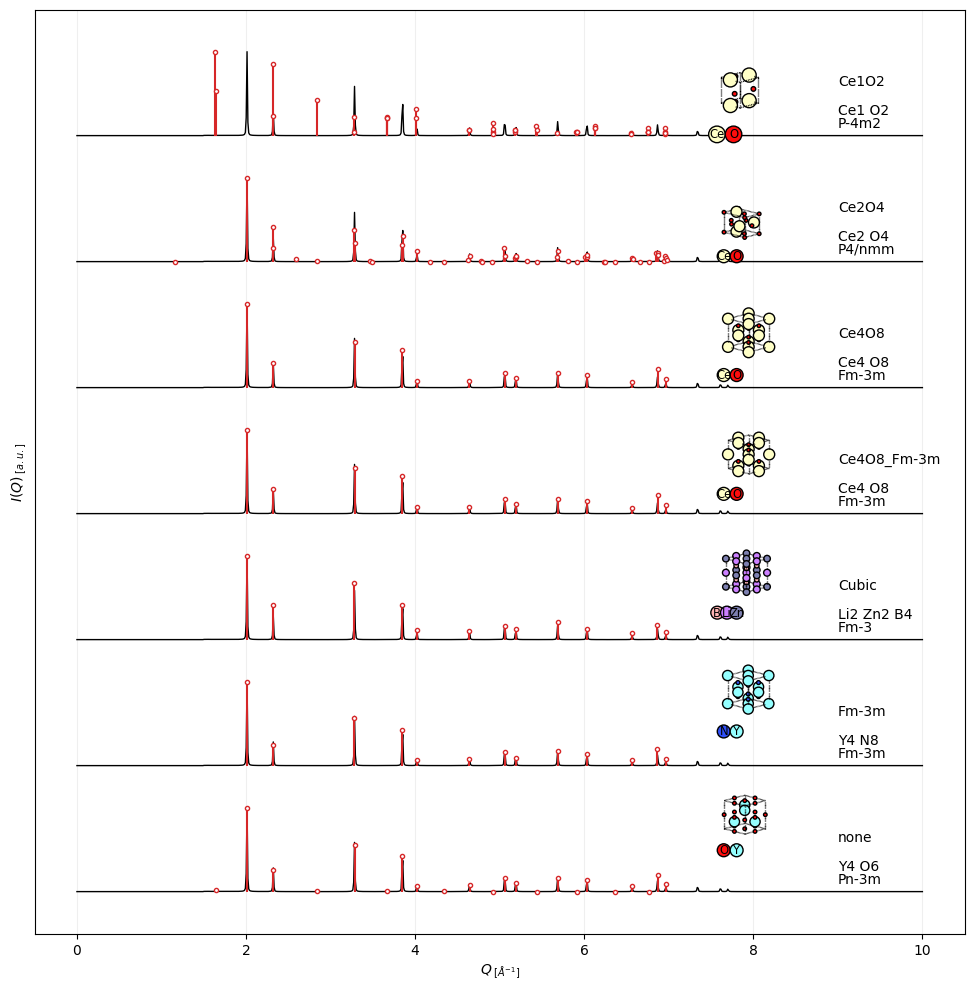

In [3]:
load_path = "crystalline_CeO2.pkl"
best = load_preprocessed_data(load_path)
plot_data(best)

Processing files...:   0%|                                                                        | 0/7 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                 | 0/79 [00:00…

Finding best structure...:   0%|                                                                 | 0/80 [00:00…

Finding best structure...:   0%|                                                                 | 0/99 [00:00…

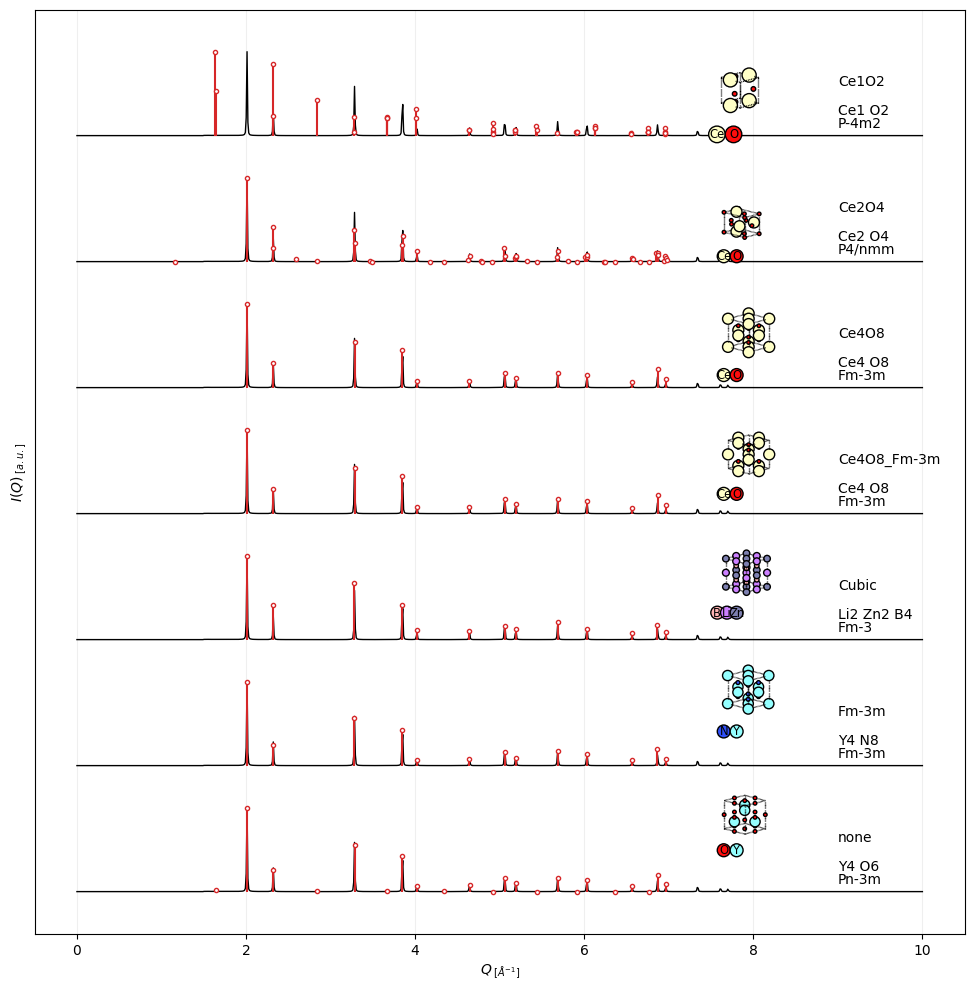

In [182]:
# Define parameters manually in the notebook cell
folder = "../crystalline_CeO2_protocol_titanrtx/"  # Path to your folder containing .pkl files
save_path = 'crystalline_CeO2.pkl'  # Set to a filename (e.g., "preprocessed.pkl") to save the processed data, or None to skip saving
load_path = None  # Set to a filename (e.g., "preprocessed.pkl") to load preprocessed data, or None to process files
debug_max = None  # Optionally limit the number of files for debugging (e.g., 10)

# Load preprocessed data if available; otherwise, process the files.
if load_path:
    best = load_preprocessed_data(load_path)
else:
    best = preprocess_data(folder, debug_max=debug_max)
    if save_path:
        save_preprocessed_data(best, save_path)

# Plot the preprocessed data.
plot_data(best)

Processing files...:   0%|                                                                        | 0/8 [00:00…

Finding best structure...:   0%|                                                                 | 0/77 [00:00…

Finding best structure...:   0%|                                                                 | 0/54 [00:00…

Finding best structure...:   0%|                                                                 | 0/69 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

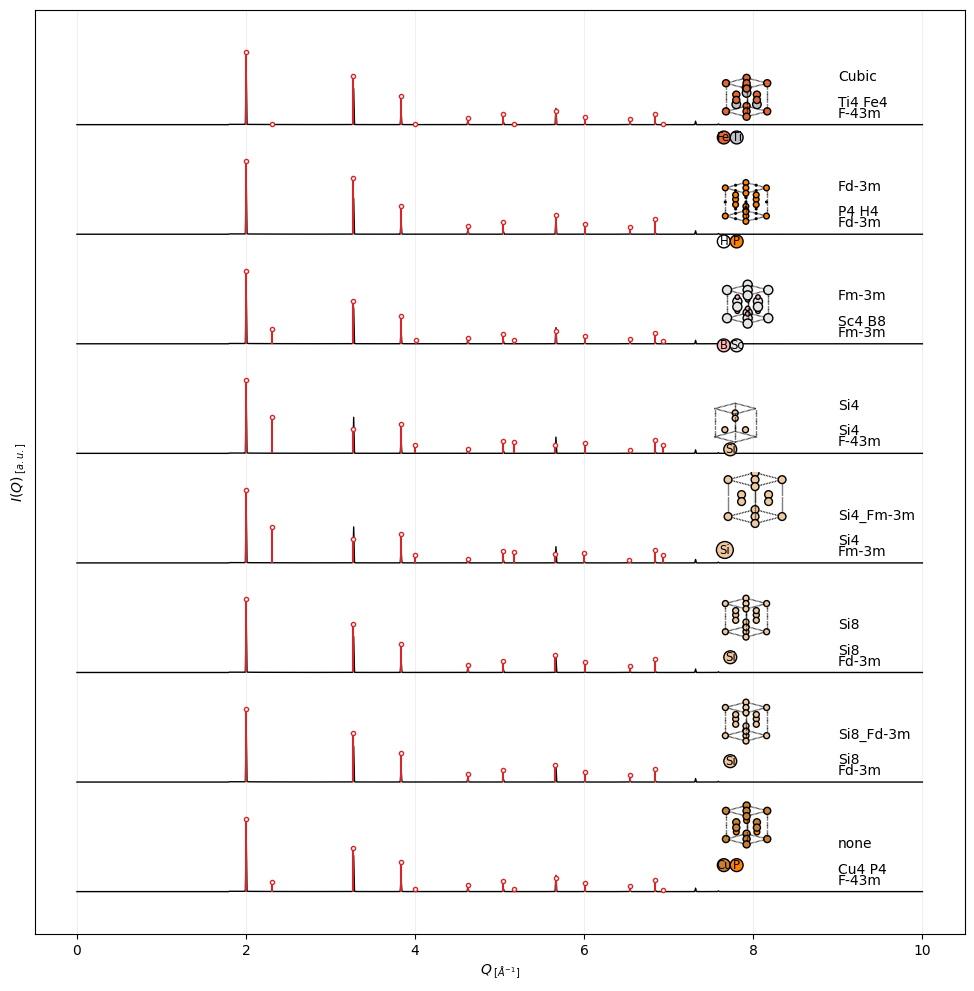

In [183]:
# Define parameters manually in the notebook cell
folder = "../crystalline_Si_protocol_titanrtx/"  # Path to your folder containing .pkl files
save_path = 'crystalline_Si.pkl'  # Set to a filename (e.g., "preprocessed.pkl") to save the processed data, or None to skip saving
load_path = None  # Set to a filename (e.g., "preprocessed.pkl") to load preprocessed data, or None to process files
debug_max = None  # Optionally limit the number of files for debugging (e.g., 10)

# Load preprocessed data if available; otherwise, process the files.
if load_path:
    best = load_preprocessed_data(load_path)
else:
    best = preprocess_data(folder, debug_max=debug_max)
    if save_path:
        save_preprocessed_data(best, save_path)

# Plot the preprocessed data.
plot_data(best)

Processing files...:   0%|                                                                       | 0/13 [00:00…

Finding best structure...:   0%|                                                                 | 0/74 [00:00…

Finding best structure...:   0%|                                                                 | 0/99 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                 | 0/98 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                 | 0/98 [00:00…

Finding best structure...:   0%|                                                                 | 0/96 [00:00…

Finding best structure...:   0%|                                                                 | 0/68 [00:00…

Finding best structure...:   0%|                                                                 | 0/93 [00:00…

Finding best structure...:   0%|                                                                 | 0/98 [00:00…

Finding best structure...:   0%|                                                                 | 0/84 [00:00…

Finding best structure...:   0%|                                                                 | 0/87 [00:00…

Finding best structure...:   0%|                                                                 | 0/94 [00:00…

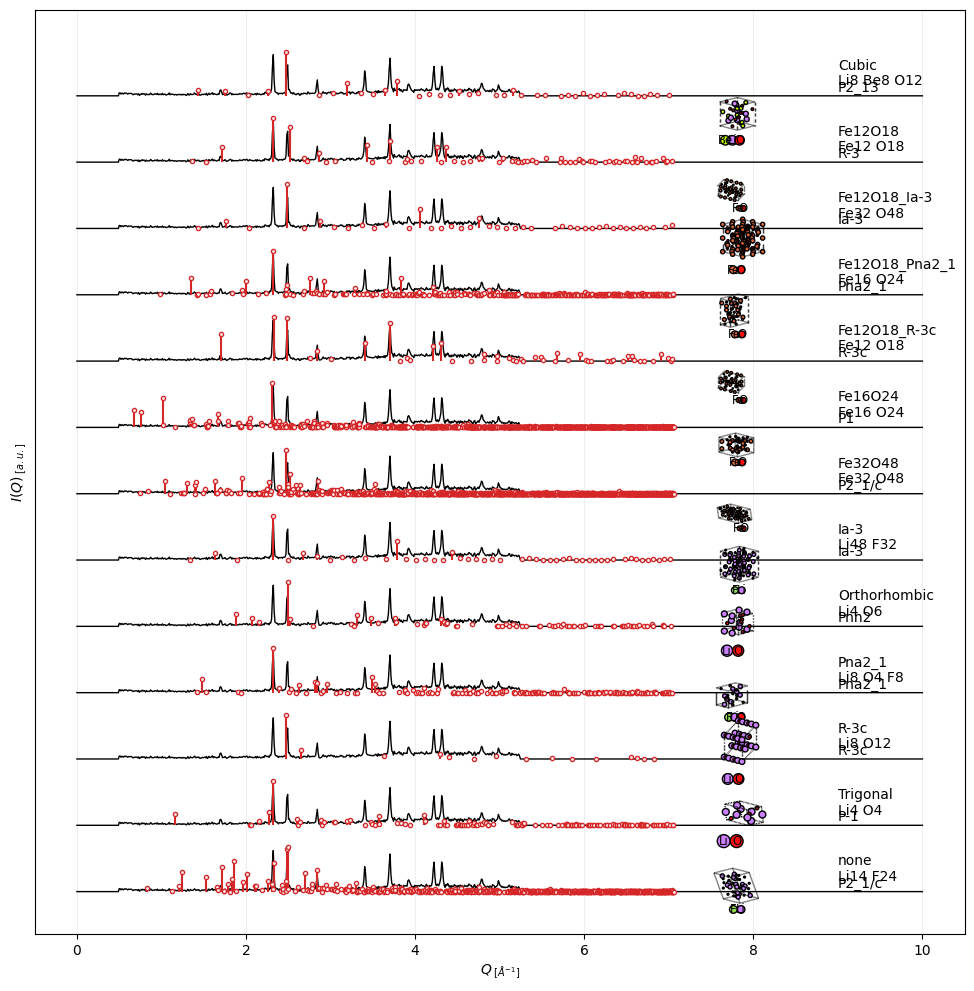

In [56]:
# Define parameters manually in the notebook cell
folder = "../crystalline_Fe2O3_protocol_titanrtx/"  # Path to your folder containing .pkl files
save_path = 'crystalline_Fe2O3.pkl'  # Set to a filename (e.g., "preprocessed.pkl") to save the processed data, or None to skip saving
load_path = None  # Set to a filename (e.g., "preprocessed.pkl") to load preprocessed data, or None to process files
debug_max = None  # Optionally limit the number of files for debugging (e.g., 10)

# Load preprocessed data if available; otherwise, process the files.
if load_path:
    best = load_preprocessed_data(load_path)
else:
    best = preprocess_data(folder, debug_max=debug_max, q_min_crop=0.5, q_max_crop=5.5)
    if save_path:
        save_preprocessed_data(best, save_path)

# Plot the preprocessed data.
plot_data(best)

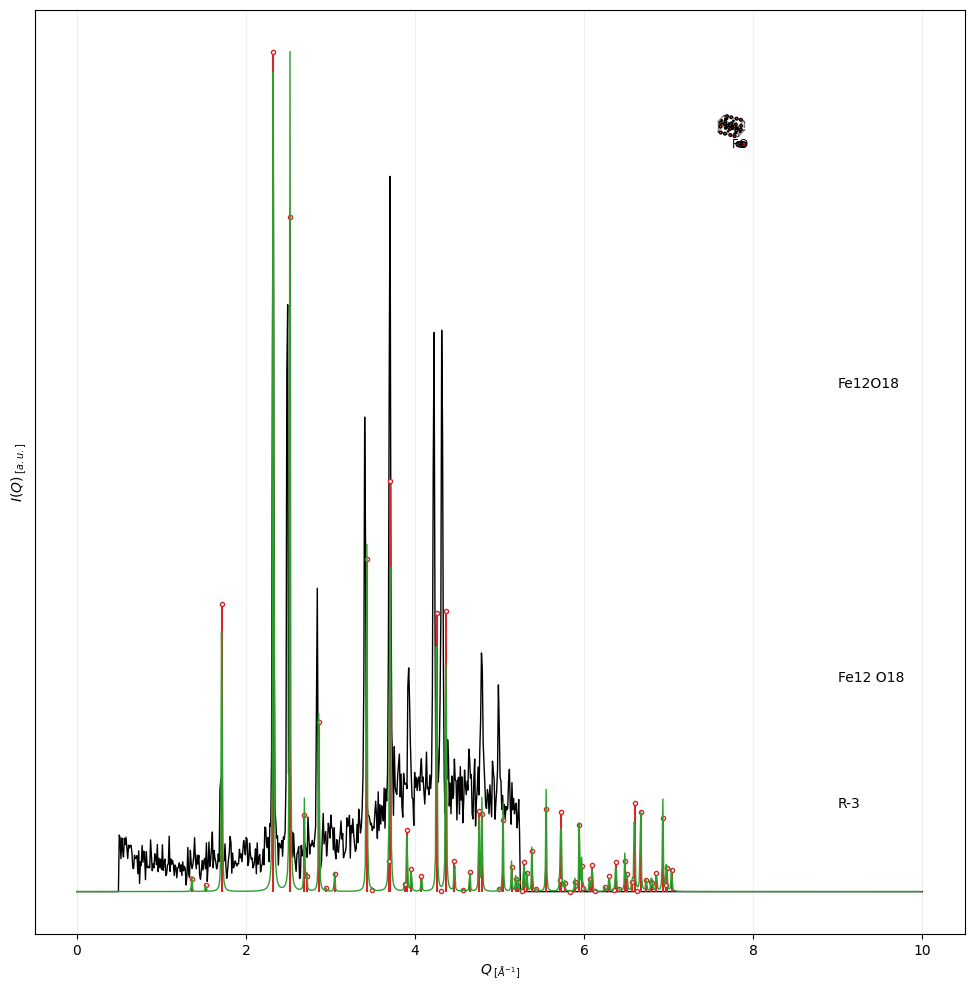

In [55]:
plot_params = {
            "figsize": (12, 12),
            "c_pred": "C3",
            "c_pred_cont": "C2",
            "pred_marker_size": 3.0,
            "atom_radii": 0.5,
            "atom_tol": 1e-5,
            "atom_offset": (0, 0, 0),
            "atom_rotation": ('45x, -15y, 90z'),
            "atom_legend_radius": 1.2,
            "struc_offset_x": 0.25,
            "struc_offset_y": 0.5,
            "struc_scale_width": 1.0,
            "struc_scale_height": 0.1,
            "struc_axis_off": True,
            "struc_add_axis_x": 10.0,
            "struc_add_axis_y": 5.0,
            "show_estimate": True
        }

# List the paths to your preprocessed .pkl files (they can come from different folders)
preprocessed_files = [
    "crystalline_Fe2O3.pkl",
    # Add more paths as needed
]

# (Optional) Specify keys to plot if you only want a subset from the merged data.
selected_keys = [
    "AFS012d_a850C_protocol_Fe12O18",
    "AFS012d_a850C_protocol_Fe12O18",
]

# Plot the mixed data. If selected_keys is None, all merged entries are plotted.
plot_mixed_data(preprocessed_files, selected_keys=selected_keys, plot_params=plot_params)

Processing files...:   0%|                                                                        | 0/7 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                 | 0/93 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

Finding best structure...:   0%|                                                                 | 0/99 [00:00…

Finding best structure...:   0%|                                                                 | 0/82 [00:00…

Finding best structure...:   0%|                                                                 | 0/93 [00:00…

Finding best structure...:   0%|                                                                | 0/100 [00:00…

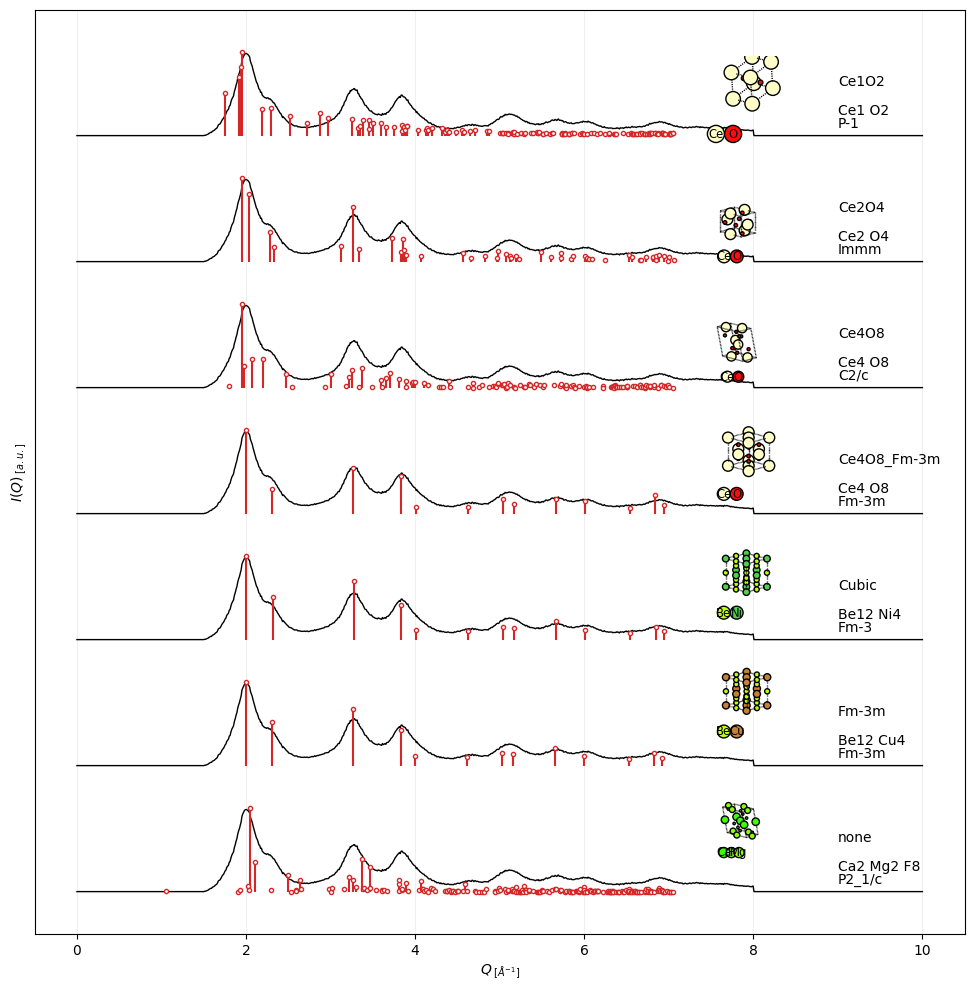

In [39]:
# Define parameters manually in the notebook cell
folder = "../particles_CeO2_protocol_titanrtx/ID5"  # Path to your folder containing .pkl files
save_path =  'particles_CeO2_ID5.pkl' # Set to a filename (e.g., "preprocessed.pkl") to save the processed data, or None to skip saving
load_path =  None # Set to a filename (e.g., "preprocessed.pkl") to load preprocessed data, or None to process files
debug_max = None  # Optionally limit the number of files for debugging (e.g., 10)

# Load preprocessed data if available; otherwise, process the files.
if load_path:
    best = load_preprocessed_data(load_path)
else:
    best = preprocess_data(folder, debug_max=debug_max, base_fwhm=0.01, size_estimate=10)
    if save_path:
        save_preprocessed_data(best, save_path)

# Plot the preprocessed data.
plot_data(best)

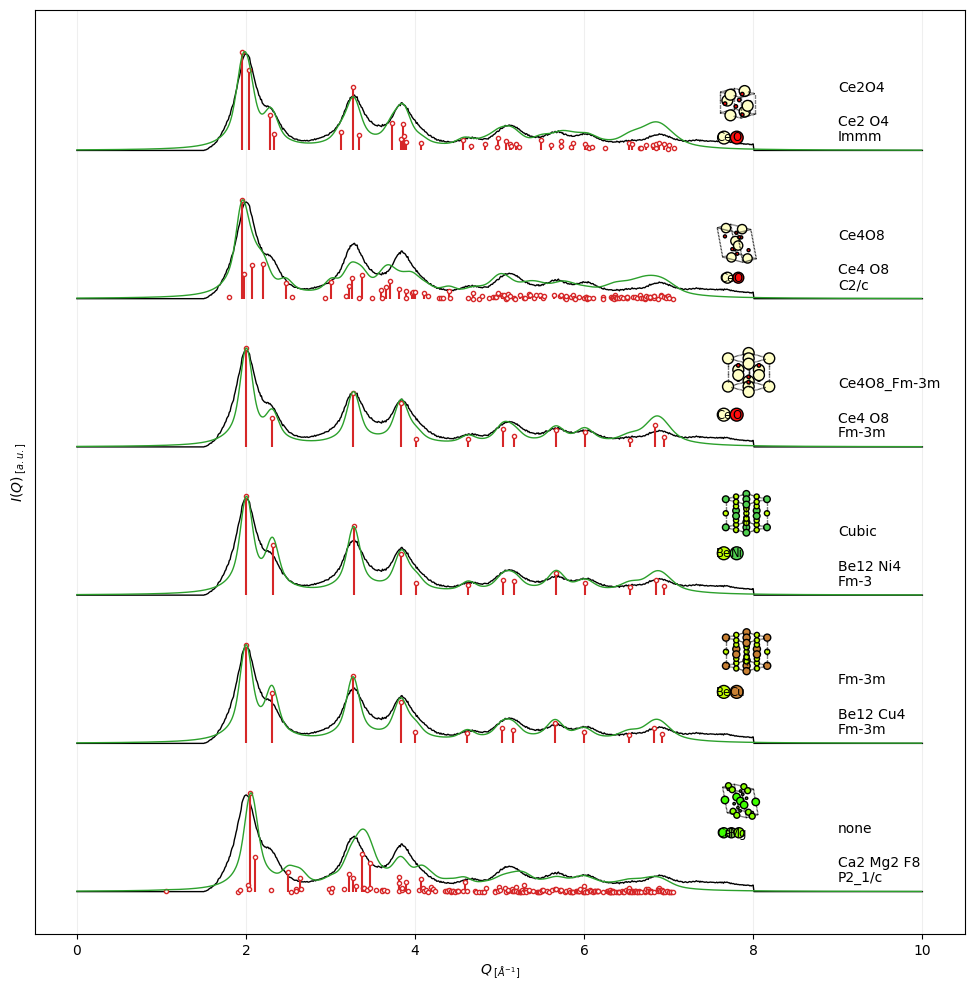

In [42]:
plot_params = {
            "figsize": (12, 12),
            "c_pred": "C3",
            "c_pred_cont": "C2",
            "pred_marker_size": 3.0,
            "atom_radii": 0.5,
            "atom_tol": 1e-5,
            "atom_offset": (0, 0, 0),
            "atom_rotation": ('45x, -15y, 90z'),
            "atom_legend_radius": 1.2,
            "struc_offset_x": 0.25,
            "struc_offset_y": 0.5,
            "struc_scale_width": 1.0,
            "struc_scale_height": 0.1,
            "struc_axis_off": True,
            "struc_add_axis_x": 10.0,
            "struc_add_axis_y": 5.0,
            "show_estimate": True
        }

# List the paths to your preprocessed .pkl files (they can come from different folders)
preprocessed_files = [
    "particles_CeO2_ID5.pkl",
    # Add more paths as needed
]

# (Optional) Specify keys to plot if you only want a subset from the merged data.
ID = 5
selected_keys = [
    f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_none",
    # f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_Ce1O2",
    f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_Ce2O4",
    f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_Ce4O8",
    f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_Cubic",
    f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_Fm-3m",
    f"Hydrolyse_ID{ID}_20min_3-56_boro_0p8_protocol_Ce4O8_Fm-3m",
                ]

# Plot the mixed data. If selected_keys is None, all merged entries are plotted.
plot_mixed_data(preprocessed_files, selected_keys=selected_keys, plot_params=plot_params)

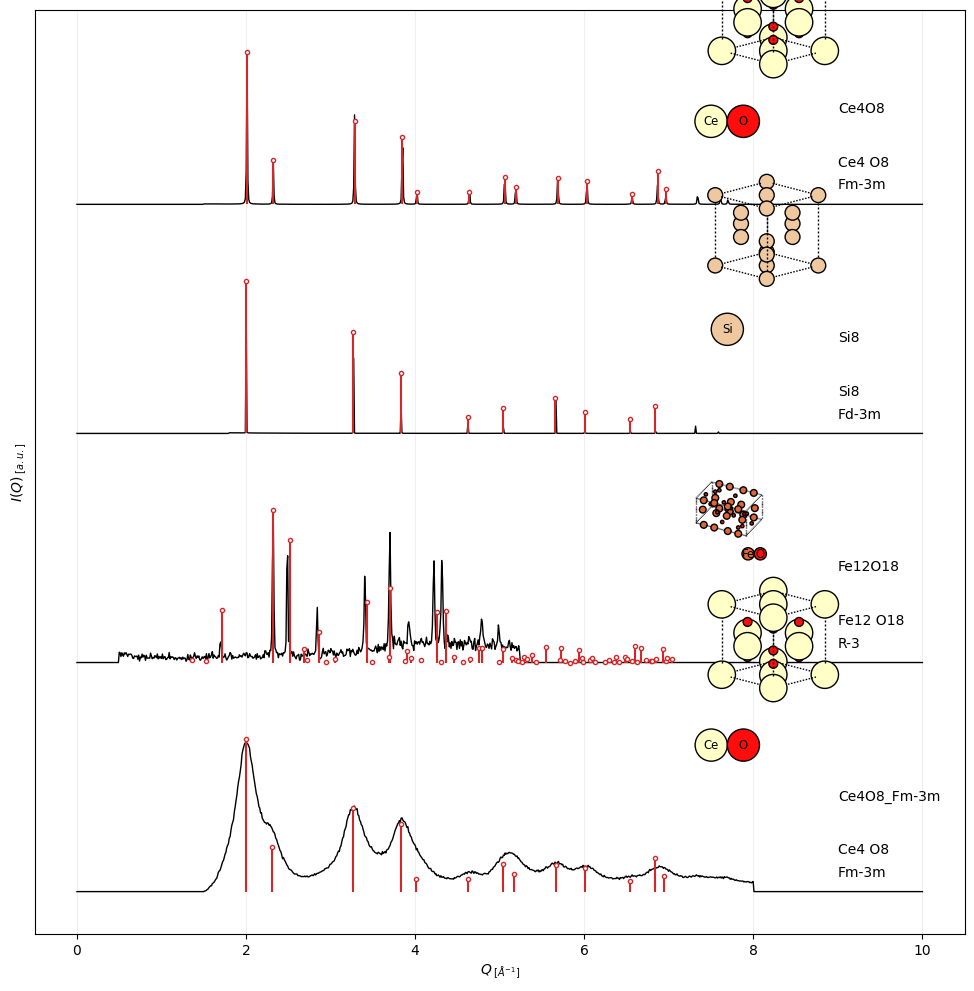

In [58]:
plot_params = {
            "figsize": (12, 12),
            "c_pred": "C3",
            "c_pred_cont": "C2",
            "pred_marker_size": 3.0,
            "atom_radii": 0.5,
            "atom_tol": 1e-5,
            "atom_offset": (0, 0, 0),
            "atom_rotation": ('45x, -15y, 90z'),
            "atom_legend_radius": 1.2,
            "struc_offset_x": 0.25,
            "struc_offset_y": 0.4,
            "struc_scale_width": 1.0,
            "struc_scale_height": 0.25,
            "struc_axis_off": True,
            "struc_add_axis_x": 10.0,
            "struc_add_axis_y": 5.0,
            "show_estimate": False
        }

# List the paths to your preprocessed .pkl files (they can come from different folders)
preprocessed_files = [
    "crystalline_CeO2.pkl",
    "crystalline_Si.pkl",
    "crystalline_Fe2O3.pkl",
    "particles_CeO2_ID5.pkl",
    # Add more paths as needed
]

# (Optional) Specify keys to plot if you only want a subset from the merged data.
selected_keys = [
    "crystalline_CeO2_BM31_protocol_Ce4O8", 
    "Si_Mythen_protocol_Si8", 
    "AFS012d_a850C_protocol_Fe12O18",
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Ce4O8_Fm-3m",
    ]

# Plot the mixed data. If selected_keys is None, all merged entries are plotted.
plot_mixed_data(preprocessed_files, selected_keys=selected_keys, plot_params=plot_params)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [9]:
import re

def format_formula_latex(formula):
    """
    Converts a plain chemical formula (like 'Ce4O8') into a LaTeX-formatted string
    with subscripts, e.g. '$\\mathrm{Ce_4O_8}$'.
    """
    # Add subscript to numbers following elements
    formatted = re.sub(r'(\D)(\d+)', r'\1_{\2}', formula)
    return rf"$\mathrm{{{formatted}}}$"

def convert_space_group_to_latex(space_group: str) -> str:
    """
    Converts a space group string to its LaTeX representation.
    
    Based on conventions as listed in the Wikipedia page on space groups,
    this function converts any occurrence of a minus sign preceding one or more digits 
    into a LaTeX overbar command. For example:
    
      "Fm-3m"  -> "$Fm\\bar{3}m$"
      "R-3c"   -> "$R\\bar{3}c$"
      "P-1"    -> "$P\\bar{1}$"
      
    Subscript notations (e.g. in "P2_1/c") are preserved because LaTeX math mode already interprets
    single-character subscripts correctly.
    
    Args:
        space_group (str): The input space group string.
        
    Returns:
        str: The LaTeX formatted string.
    """
    # Replace each occurrence of a hyphen followed by one or more digits with LaTeX bar notation.
    latex_str = re.sub(r'-(\d+)', r'\\bar{\1}', space_group)
    # Enclose the result in $ signs for LaTeX math mode.
    return f'${latex_str}$'


In [10]:
with open("crystalline_CeO2.pkl", "rb") as f:
    crystalline_CeO2 = pickle.load(f)["crystalline_CeO2_BM31_protocol_Ce4O8"]
    CeO2_q = crystalline_CeO2["exp_q"]
    CeO2_iq = crystalline_CeO2["exp_i"]
    CeO2_q_disc = np.array(crystalline_CeO2["pxrd"]["q_disc"][0])
    CeO2_iq_disc = np.array(crystalline_CeO2["pxrd"]["iq_disc"][0]) / 100
    CeO2_struc = crystalline_CeO2["result"]["struct"]
    CeO2_spacegroup = extract_space_group_symbol(crystalline_CeO2["result"]["cif_str"])
    CeO2_formula = "".join(extract_formula_nonreduced(crystalline_CeO2["result"]["cif_str"]).split(" "))

with open("crystalline_Si.pkl", "rb") as f:
    crystalline_Si = pickle.load(f)["Si_Mythen_protocol_Si8"]
    Si_q = crystalline_Si["exp_q"]
    Si_iq = crystalline_Si["exp_i"]
    Si_q_disc = np.array(crystalline_Si["pxrd"]["q_disc"][0])
    Si_iq_disc = np.array(crystalline_Si["pxrd"]["iq_disc"][0]) / 100
    Si_struc = crystalline_Si["result"]["struct"]
    Si_spacegroup = extract_space_group_symbol(crystalline_Si["result"]["cif_str"])
    Si_formula = "".join(extract_formula_nonreduced(crystalline_Si["result"]["cif_str"]).split(" "))

with open("crystalline_Fe2O3.pkl", "rb") as f:
    crystalline_Fe2O3 = pickle.load(f)["AFS012d_a850C_protocol_Fe12O18"]
    Fe2O3_q = crystalline_Fe2O3["exp_q"]
    Fe2O3_iq = crystalline_Fe2O3["exp_i"]
    Fe2O3_q_disc = np.array(crystalline_Fe2O3["pxrd"]["q_disc"][0])
    Fe2O3_iq_disc = np.array(crystalline_Fe2O3["pxrd"]["iq_disc"][0]) / 100
    Fe2O3_struc = crystalline_Fe2O3["result"]["struct"]
    Fe2O3_spacegroup = extract_space_group_symbol(crystalline_Fe2O3["result"]["cif_str"])
    Fe2O3_formula = "".join(extract_formula_nonreduced(crystalline_Fe2O3["result"]["cif_str"]).split(" "))

with open("particles_CeO2_ID5.pkl", "rb") as f:
    CeO2_particles = pickle.load(f)["Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Ce4O8"]
    CeO2_particles_q = CeO2_particles["exp_q"]
    CeO2_particles_iq = CeO2_particles["exp_i"]
    CeO2_particles_q_disc = np.array(CeO2_particles["pxrd"]["q_disc"][0])
    CeO2_particles_iq_disc = np.array(CeO2_particles["pxrd"]["iq_disc"][0]) / 100
    CeO2_particles_q_pred = np.array(CeO2_particles["pxrd"]["q"])
    CeO2_particles_iq_pred = np.array(CeO2_particles["pxrd"]["iq"])
    CeO2_particles_struc = CeO2_particles["result"]["struct"]
    CeO2_particles_spacegroup = extract_space_group_symbol(CeO2_particles["result"]["cif_str"])
    CeO2_particles_formula = "".join(extract_formula_nonreduced(CeO2_particles["result"]["cif_str"]).split(" "))

CeO2_formula_latex = format_formula_latex(CeO2_formula)
Si_formula_latex = format_formula_latex(Si_formula)
Fe2O3_formula_latex = format_formula_latex(Fe2O3_formula)
CeO2_particles_formula_latex = format_formula_latex(CeO2_particles_formula)

CeO2_spacegroup_latex = convert_space_group_to_latex(CeO2_spacegroup)
Si_spacegroup_latex = convert_space_group_to_latex(Si_spacegroup)
Fe2O3_spacegroup_latex = convert_space_group_to_latex(Fe2O3_spacegroup)
CeO2_particles_spacegroup_latex = convert_space_group_to_latex(CeO2_particles_spacegroup)

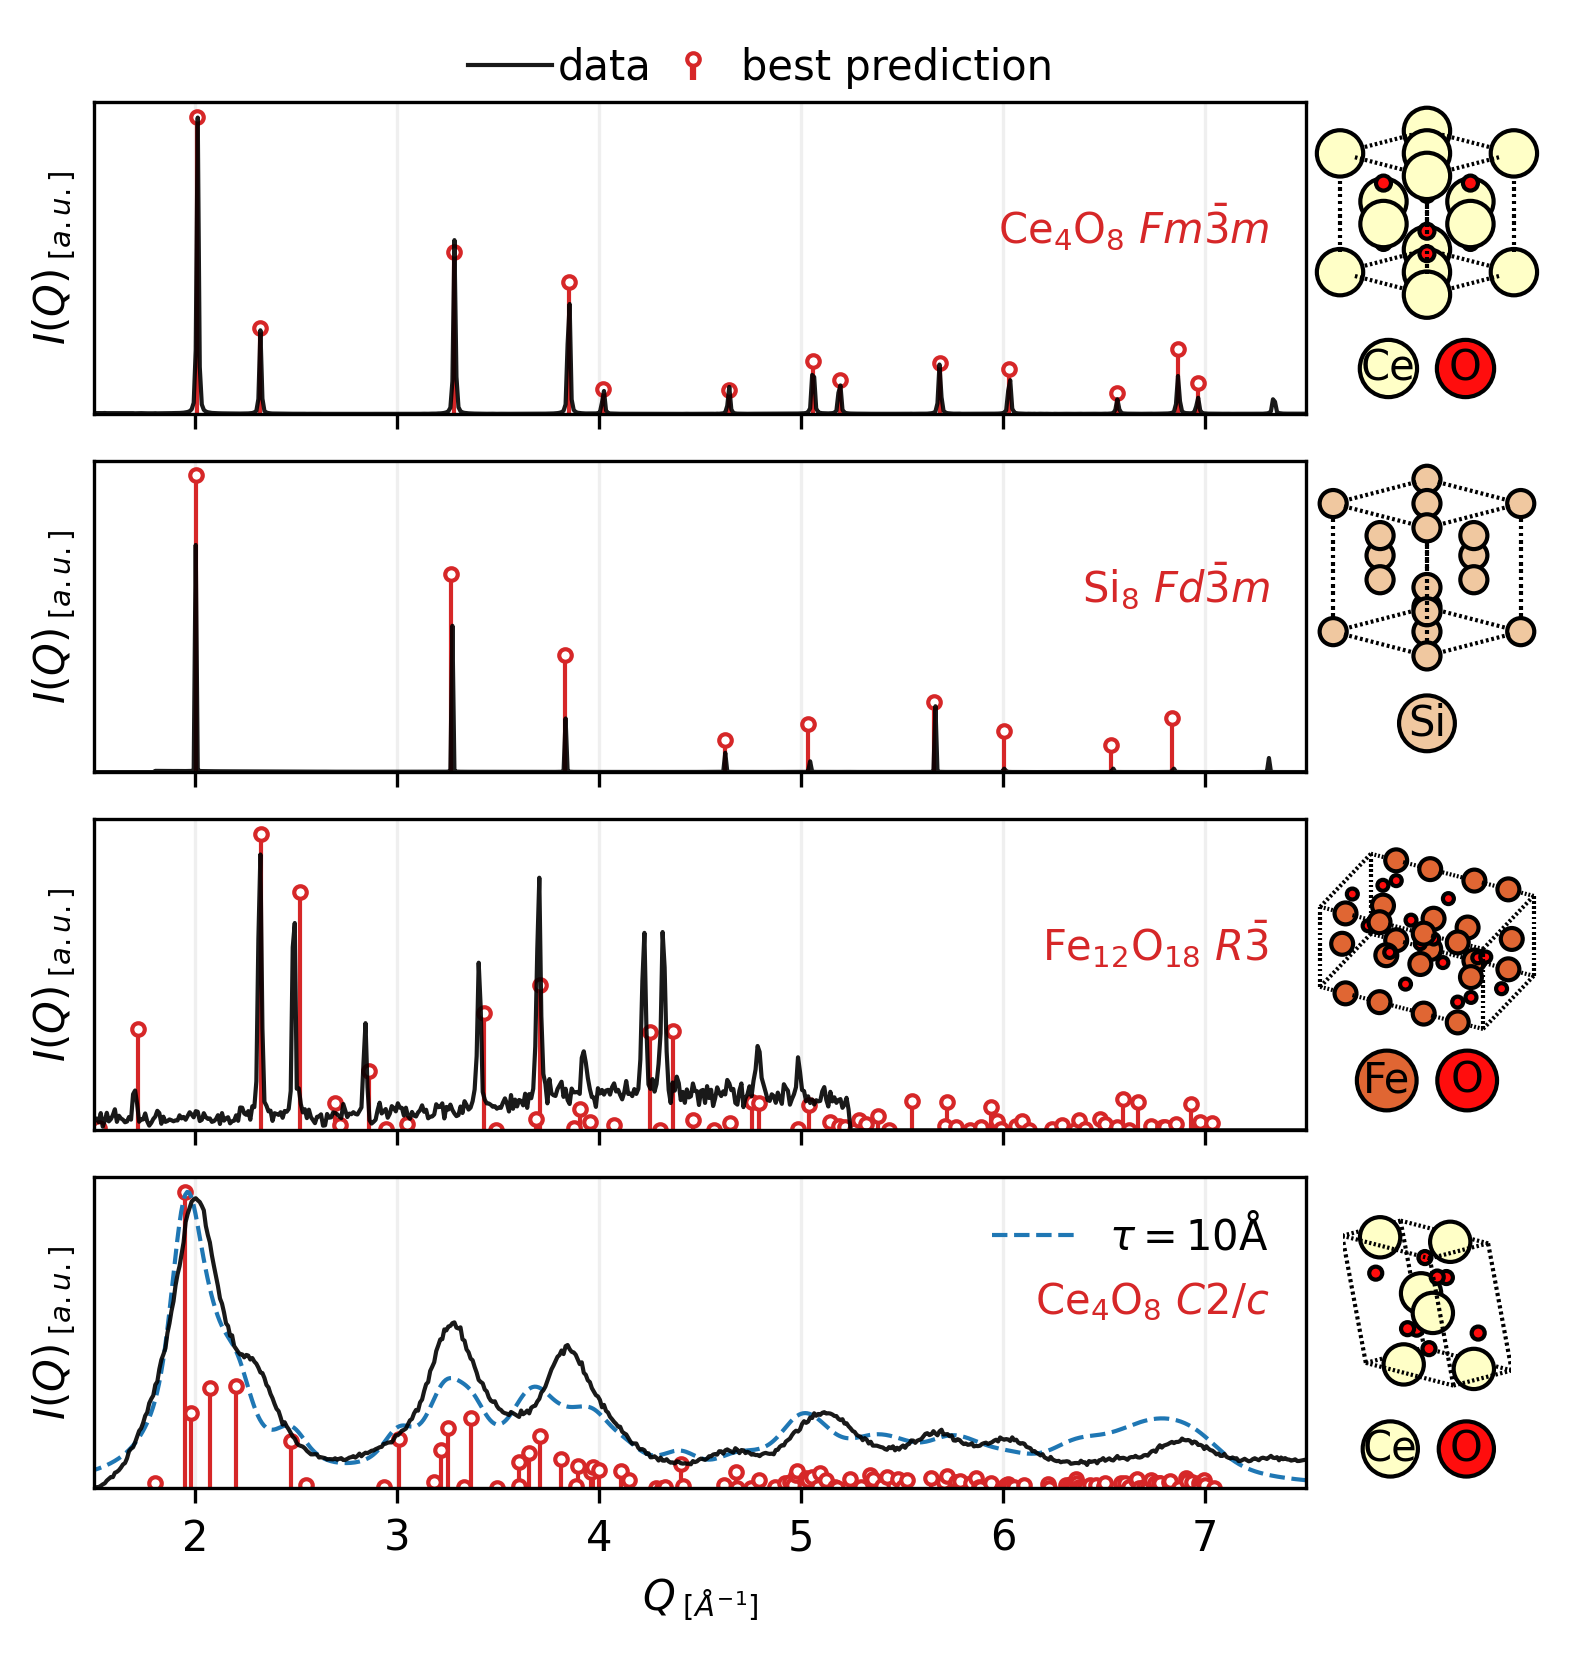

In [84]:
# Create a figure
figsize=1.2
fig = plt.figure(figsize=(5.5*figsize, 5*figsize), dpi=300)

# Main variables for the stem line style and width
stem_linestyle = '-'
stem_linewidth = 1.0

# Atoms
atoms_radius = 50
atoms_label_size = 10

# Marker size
ms = 3

tx, ty = 0.97, 0.6

# Define GridSpec with no horizontal spacing
gs = gridspec.GridSpec(4, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1, 1],
                       hspace=0.15, wspace=-0.1)

# ---------------------------
# Global legend handles with an actual stem icon using the main variables
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
legend_handles = [
    Line2D([], [], color='k', lw=1),
    (Line2D([], [], color='C3', lw=stem_linewidth, linestyle=stem_linestyle),
     Line2D([], [], color='C3', lw=0, marker='o', markersize=ms,
            markerfacecolor='white', markeredgecolor='C3', markeredgewidth=1.0))
]
legend_labels = ['data', 'prediction']
# ---------------------------

# ---------------------------
# Unit cell view adjustment function
def adjust_unit_cell_view(ax, zoom=1.0, dx=0.0, dy=0.0):
    """
    Adjust the view of the unit cell plotted on ax.
    
    Parameters:
      ax   : matplotlib Axes object.
      zoom : Zoom factor (values <1 zoom in, >1 zoom out).
      dx   : Horizontal offset.
      dy   : Vertical offset.
    """
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    x_center = (x0 + x1) / 2.0
    y_center = (y0 + y1) / 2.0
    x_half = (x1 - x0) / 2.0 * zoom
    y_half = (y1 - y0) / 2.0 * zoom
    ax.set_xlim(x_center - x_half + dx, x_center + x_half + dx)
    ax.set_ylim(y_center - y_half + dy, y_center + y_half + dy)
# ---------------------------

import matplotlib.transforms as mtransforms
from matplotlib.patches import Circle

def fixed_size_circle(x, y, radius_points, ax, **kwargs):
    """
    Create a Circle patch with a constant size in display (point) units.
    
    Parameters:
      x, y         : Center of the circle in data coordinates.
      radius_points: Desired radius in points (1 point = 1/72 inch).
      ax           : The axes on which the circle will be drawn.
      kwargs       : Other keyword arguments for Circle.
      
    Returns:
      A Circle patch whose size is fixed in display units.
    """
    inv = ax.transData.inverted()
    dp = inv.transform((radius_points, 0)) - inv.transform((0, 0))
    data_radius = dp[0]
    return Circle((x, y), data_radius, **kwargs)

# ---------------------------
# Plotting Crystalline Ceria (row 0)
ax_ce_pxrd = fig.add_subplot(gs[0,0])
# Plot prediction (stem) first with lower zorder
stem = ax_ce_pxrd.stem(CeO2_q_disc, CeO2_iq_disc, linefmt='C3-', markerfmt='C4o', basefmt=' ', label='best prediction')
plt.setp(stem.stemlines, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=ms, markerfacecolor='white', markeredgecolor='C3', markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
# Plot data on top with 90% opacity and higher zorder
ax_ce_pxrd.plot(CeO2_q, CeO2_iq, lw=1, c='k', alpha=0.9, zorder=3, label='data')
ax_ce_pxrd.set(xlim=(1.5, 7.5), ylim=(0,None), yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_ce_pxrd.grid(alpha=0.2, axis='x')
ax_ce_pxrd.tick_params(axis='x', labelbottom=False)  # Remove x ticklabels

ax_ce_pxrd.legend(loc='upper center', bbox_to_anchor=(0.55, 1.3), ncol=2, frameon=False, columnspacing=0.0, handletextpad=0.15)

ax_ce_struc = fig.add_subplot(gs[0,1])
ax_ce_struc.axis('off')
plot_unit_cell_with_boundaries(CeO2_struc, ax=ax_ce_struc, radii=0.5)
ylim = ax_ce_struc.get_ylim()
new_ylim = (ylim[0] - 4, ylim[1])
ax_ce_struc.set_ylim(new_ylim)
# Adjust view for Ceria
uc_zoom_ce = 1.0   
uc_dx_ce = 0.0     
uc_dy_ce = 0.0     
adjust_unit_cell_view(ax_ce_struc, zoom=uc_zoom_ce, dx=uc_dx_ce, dy=uc_dy_ce)

unique_species = sorted(set([site.species_string for site in CeO2_struc]))
n_species = len(unique_species)
legend_y = ax_ce_struc.get_ylim()[0] + 2.0
x_min, x_max = ax_ce_struc.get_xlim()
x_positions = np.linspace(x_min, x_max, n_species + 2)[1:-1]
for x, species in zip(x_positions, unique_species):
    try:
        atom_color = colors.jmol_colors[atomic_numbers[species]]
    except KeyError:
        atom_color = 'black'
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius, ax=ax_ce_struc,
                             edgecolor='black', facecolor=atom_color, lw=1)
    ax_ce_struc.add_patch(circ)
    ax_ce_struc.text(x, legend_y, species, color='black', ha='center', va='center', fontsize=atoms_label_size)
# Add temporary space group text to the unit cell
ax_ce_pxrd.text(tx, ty, CeO2_formula_latex + ' ' + CeO2_spacegroup_latex, transform=ax_ce_pxrd.transAxes,
                 ha='right', va='center', fontsize=atoms_label_size, color='C3')

# ---------------------------
# Plotting Crystalline Si (row 1)
ax_si_pxrd = fig.add_subplot(gs[1,0], sharex=ax_ce_pxrd)
stem = ax_si_pxrd.stem(Si_q_disc, Si_iq_disc, linefmt='C3-', markerfmt='C4o', basefmt=' ')
plt.setp(stem.stemlines, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=ms, markerfacecolor='white', markeredgecolor='C3', markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_si_pxrd.plot(Si_q, Si_iq, lw=1, c='k', alpha=0.9, zorder=3)
ax_si_pxrd.set(xlim=(1.5, 7.5), ylim=(0,None), yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_si_pxrd.grid(alpha=0.2, axis='x')
ax_si_pxrd.tick_params(axis='x', labelbottom=False)  # Remove x ticklabels

ax_si_struc = fig.add_subplot(gs[1,1])
ax_si_struc.axis('off')
plot_unit_cell_with_boundaries(Si_struc, ax=ax_si_struc, radii=0.5)
ylim = ax_si_struc.get_ylim()
ax_si_struc.set_ylim((ylim[0] - 4, ylim[1]))
uc_zoom_si = 1.0   
uc_dx_si = 0.0     
uc_dy_si = 0.0     
adjust_unit_cell_view(ax_si_struc, zoom=uc_zoom_si, dx=uc_dx_si, dy=uc_dy_si)

unique_species = sorted(set([site.species_string for site in Si_struc]))
x_positions = np.linspace(*ax_si_struc.get_xlim(), len(unique_species) + 2)[1:-1]
legend_y = ax_si_struc.get_ylim()[0] + 2.0
for x, species in zip(x_positions, unique_species):
    try:
        atom_color = colors.jmol_colors[atomic_numbers[species]]
    except KeyError:
        atom_color = 'black'
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius, ax=ax_si_struc,
                             edgecolor='black', facecolor=atom_color, lw=1)
    ax_si_struc.add_patch(circ)
    ax_si_struc.text(x, legend_y, species, color='black', ha='center', va='center', fontsize=atoms_label_size)
ax_si_pxrd.text(tx, ty, Si_formula_latex + ' ' + Si_spacegroup_latex, transform=ax_si_pxrd.transAxes,
                 ha='right', va='center', fontsize=atoms_label_size, color='C3')

# ---------------------------
# Plotting Crystalline Fe2O3 (row 2)
ax_fe_pxrd = fig.add_subplot(gs[2,0], sharex=ax_ce_pxrd)
stem = ax_fe_pxrd.stem(Fe2O3_q_disc, Fe2O3_iq_disc, linefmt='C3-', markerfmt='C4o', basefmt=' ')
plt.setp(stem.stemlines, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=ms, markerfacecolor='white', markeredgecolor='C3', markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_fe_pxrd.plot(Fe2O3_q, Fe2O3_iq, lw=1, c='k', alpha=0.9, zorder=3)
ax_fe_pxrd.set(xlim=(1.5, 7.5), ylim=(0,None), yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_fe_pxrd.grid(alpha=0.2, axis='x')
ax_fe_pxrd.tick_params(axis='x', labelbottom=False)  # Remove x ticklabels

ax_fe_struc = fig.add_subplot(gs[2,1])
ax_fe_struc.axis('off')
plot_unit_cell_with_boundaries(Fe2O3_struc, ax=ax_fe_struc, radii=0.5)
ylim = ax_fe_struc.get_ylim()
ax_fe_struc.set_ylim((ylim[0] - 4, ylim[1]))
uc_zoom_fe = 1.2   
uc_dx_fe = 0.0     
uc_dy_fe = 0.0     
adjust_unit_cell_view(ax_fe_struc, zoom=uc_zoom_fe, dx=uc_dx_fe, dy=uc_dy_fe)

unique_species = sorted(set([site.species_string for site in Fe2O3_struc]))
x_positions = np.linspace(*ax_fe_struc.get_xlim(), len(unique_species) + 2)[1:-1]
legend_y = ax_fe_struc.get_ylim()[0] + 3.0
for x, species in zip(x_positions, unique_species):
    try:
        atom_color = colors.jmol_colors[atomic_numbers[species]]
    except KeyError:
        atom_color = 'black'
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius, ax=ax_fe_struc,
                             edgecolor='black', facecolor=atom_color, lw=1)
    ax_fe_struc.add_patch(circ)
    ax_fe_struc.text(x, legend_y, species, color='black', ha='center', va='center', fontsize=atoms_label_size)
ax_fe_pxrd.text(tx, ty, Fe2O3_formula_latex + ' ' + Fe2O3_spacegroup_latex, transform=ax_fe_pxrd.transAxes,
                 ha='right', va='center', fontsize=atoms_label_size, color='C3')

# ---------------------------
# Plotting Particles CeO2 (row 3)
ax_particles_pxrd = fig.add_subplot(gs[3,0], sharex=ax_ce_pxrd)
stem = ax_particles_pxrd.stem(CeO2_particles_q_disc, CeO2_particles_iq_disc, linefmt='C3-', markerfmt='C4o', basefmt=' ')
plt.setp(stem.stemlines, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=ms, markerfacecolor='white', markeredgecolor='C3', markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_particles_pxrd.plot(CeO2_particles_q, CeO2_particles_iq, lw=1, c='k', alpha=0.9, zorder=3)
ax_particles_pxrd.plot(CeO2_particles_q_pred, CeO2_particles_iq_pred, label=r'$\tau = 10$Å', color='C0', ls='--', lw=1)
ax_particles_pxrd.set(xlim=(1.5, 7.5), ylim=(0,None), yticklabels=[], yticks=[], 
                      xlabel=r"$Q_{\;[Å^{-1}]}$", ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_particles_pxrd.grid(alpha=0.2, axis='x')
ax_particles_pxrd.legend(frameon=False)
# (Keep tick labels on the bottom row)

ax_particles_struc = fig.add_subplot(gs[3,1])
ax_particles_struc.axis('off')
plot_unit_cell_with_boundaries(CeO2_particles_struc, ax=ax_particles_struc, radii=0.5)
ylim = ax_particles_struc.get_ylim()
ax_particles_struc.set_ylim((ylim[0] - 4, ylim[1]))
uc_zoom_particles = 1.2
uc_dx_particles = 0.0   
uc_dy_particles = 0.5    
adjust_unit_cell_view(ax_particles_struc, zoom=uc_zoom_particles, dx=uc_dx_particles, dy=uc_dy_particles)

unique_species = sorted(set([site.species_string for site in CeO2_particles_struc]))
xmin, xmax = ax_particles_struc.get_xlim()
x_positions = np.linspace(xmin*(uc_zoom_particles - 1.0)-2.0, xmax*uc_zoom_particles, len(unique_species) + 2)[1:-1]
legend_y = ax_particles_struc.get_ylim()[0] + 2.0
for x, species in zip(x_positions, unique_species):
    try:
        atom_color = colors.jmol_colors[atomic_numbers[species]]
    except KeyError:
        atom_color = 'black'
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius*uc_zoom_particles*1.1, ax=ax_particles_struc,
                             edgecolor='black', facecolor=atom_color, lw=1)
    ax_particles_struc.add_patch(circ)
    ax_particles_struc.text(x, legend_y, species, color='black', ha='center', va='center', fontsize=atoms_label_size)
ax_particles_pxrd.text(tx, ty, CeO2_particles_formula_latex + ' ' + CeO2_particles_spacegroup_latex, transform=ax_particles_pxrd.transAxes,
                          ha='right', va='center', fontsize=atoms_label_size, color='C3')


# # ---------------------------
# # Global legend
# fig.legend(
#     handles=legend_handles,
#     labels=legend_labels,
#     handler_map={tuple: HandlerTuple(ndivide=None)},
#     loc='upper center',
#     bbox_to_anchor=(0.425, 0.95),  # Adjust this tuple to move the legend closer or further
#     ncol=2,
#     frameon=False
# )

fig.savefig("experimental_data_CeO2_Si_Fe2O3_CeriaParticles.pdf", bbox_inches='tight')
plt.show()


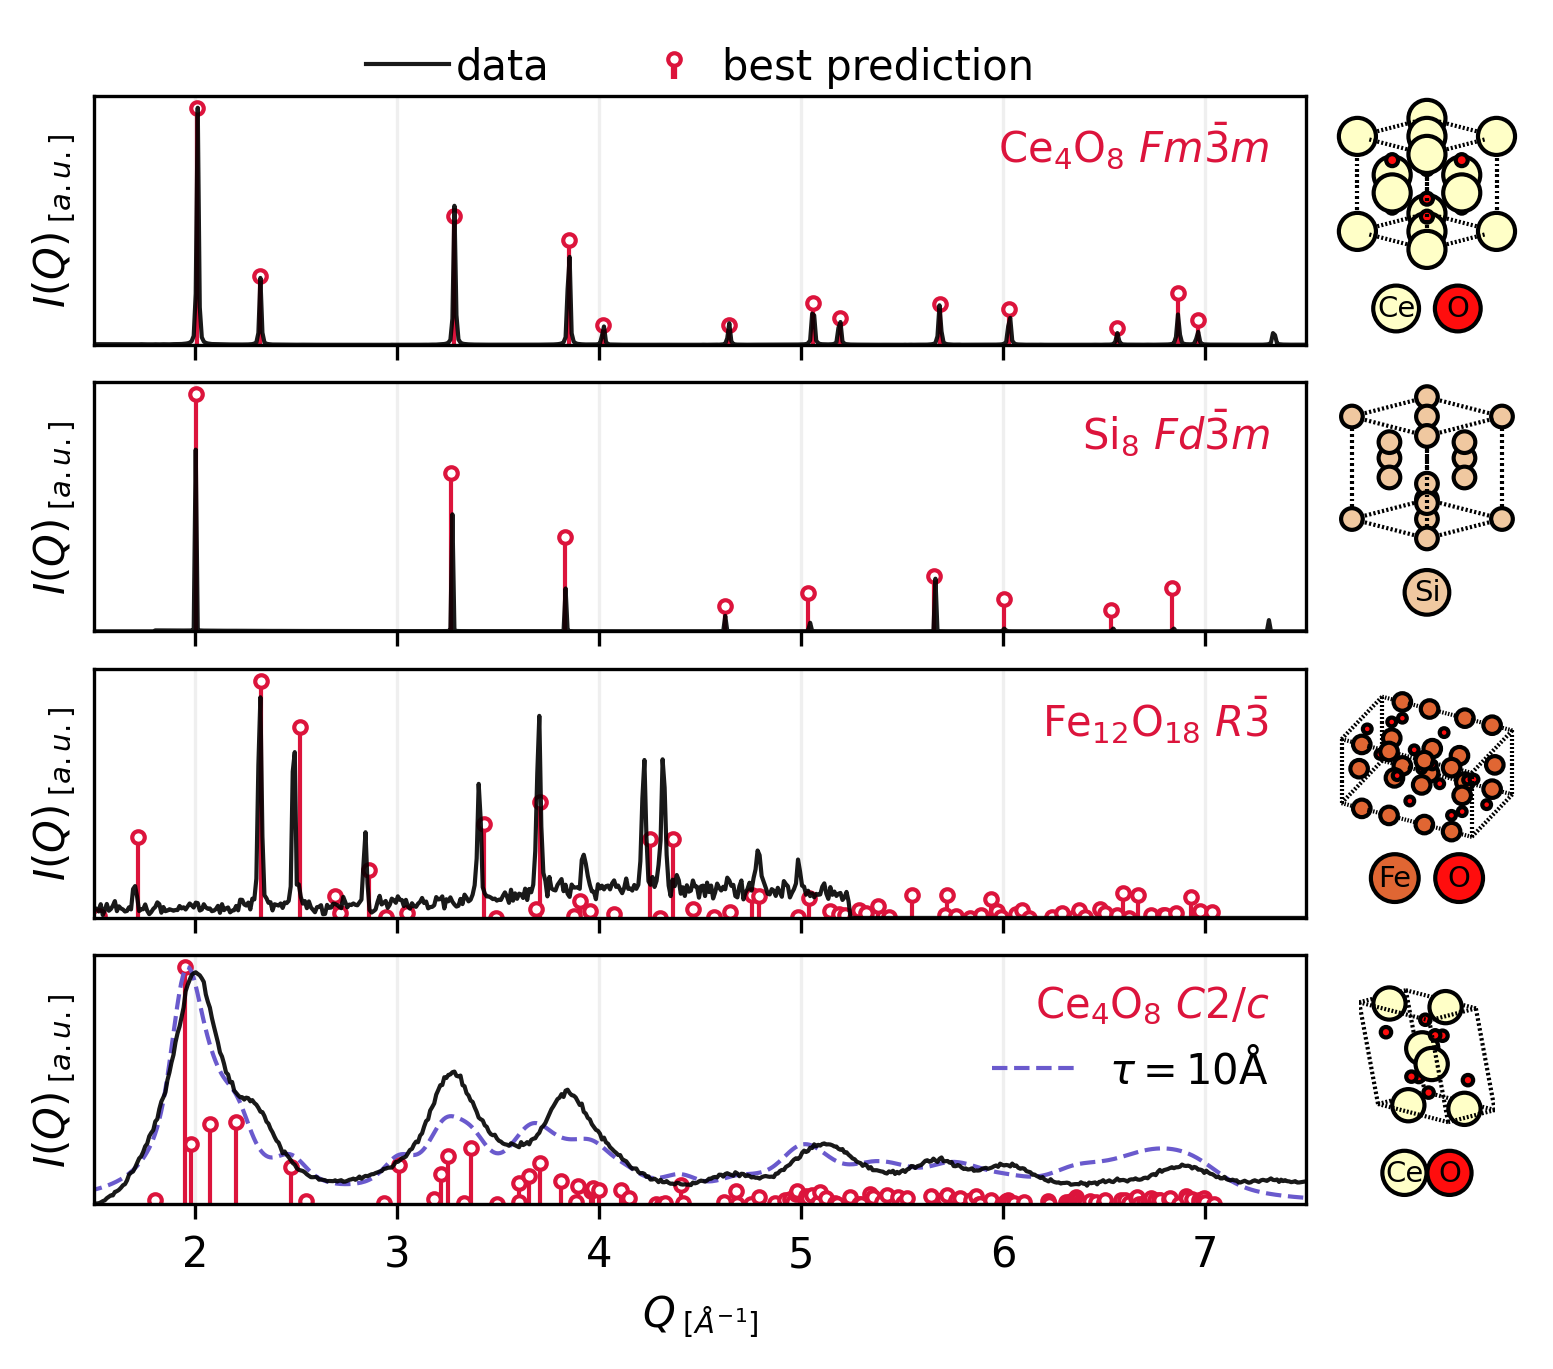

In [16]:
# ---------------------------
# Centralized plotting style settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.transforms as mtransforms
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# Colors
color_data = 'k'
color_prediction_stem = "#DC143C"# '#B8860B'  # Example: GoldenRod
color_prediction_marker = "#DC143C" #'#8B4513'  # Example: SaddleBrown
color_prediction_label = "#DC143C" #'#B8860B'
color_particles_fit = '#6A5ACD'
atom_edge_color = 'black'
legend_text_color = 'black'

# Styles and sizes
figsize = 1.2
stem_linestyle = '-'
stem_linewidth = 1.0
atoms_radius = 50
atoms_label_size = 7
pred_label_size = 10
marker_size = 3
tx, ty = 0.97, 0.8

# Create figure
fig = plt.figure(figsize=(5.5 * figsize, 4 * figsize), dpi=300)

# Define GridSpec
gs = gridspec.GridSpec(4, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1, 1],
                       hspace=0.15, wspace=-0.1)

# ---------------------------
# Functions
def adjust_unit_cell_view(ax, zoom=1.0, dx=0.0, dy=0.0):
    """Adjust view of unit cell plot."""
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    x_center, y_center = (x0 + x1) / 2, (y0 + y1) / 2
    x_half, y_half = (x1 - x0) / 2 * zoom, (y1 - y0) / 2 * zoom
    ax.set_xlim(x_center - x_half + dx, x_center + x_half + dx)
    ax.set_ylim(y_center - y_half + dy, y_center + y_half + dy)

def fixed_size_circle(x, y, radius_points, ax, **kwargs):
    """Create circle with constant display size."""
    inv = ax.transData.inverted()
    dp = inv.transform((radius_points, 0)) - inv.transform((0, 0))
    data_radius = dp[0]
    return Circle((x, y), data_radius, **kwargs)

def get_atom_color(species):
    """Safely get atom color from jmol_colors."""
    try:
        return colors.jmol_colors[atomic_numbers[species]]
    except (KeyError, TypeError):
        return 'black'
# ---------------------------

# ---------------------------
# Plotting Crystalline Ceria (row 0)
ax_ce_pxrd = fig.add_subplot(gs[0, 0])
stem = ax_ce_pxrd.stem(CeO2_q_disc, CeO2_iq_disc, linefmt='-', markerfmt='o', basefmt=' ', label='best prediction')
plt.setp(stem.stemlines, color=color_prediction_stem, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=marker_size, markerfacecolor='white', markeredgecolor=color_prediction_stem, markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_ce_pxrd.plot(CeO2_q, CeO2_iq, lw=1, c=color_data, alpha=0.9, zorder=3, label='data')
ax_ce_pxrd.set(xlim=(1.5, 7.5), ylim=(0, None), yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_ce_pxrd.grid(alpha=0.2, axis='x')
ax_ce_pxrd.tick_params(axis='x', labelbottom=False)
ax_ce_pxrd.legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.35), handletextpad=0.15)

ax_ce_struc = fig.add_subplot(gs[0, 1])
ax_ce_struc.axis('off')
plot_unit_cell_with_boundaries(CeO2_struc, ax=ax_ce_struc, radii=0.5)
ylim = ax_ce_struc.get_ylim()
ax_ce_struc.set_ylim((ylim[0] - 4, ylim[1]))
adjust_unit_cell_view(ax_ce_struc)

unique_species = sorted(set(site.species_string for site in CeO2_struc))
x_positions = np.linspace(*ax_ce_struc.get_xlim(), len(unique_species) + 2)[1:-1]
legend_y = ax_ce_struc.get_ylim()[0] + 2.0
for x, species in zip(x_positions, unique_species):
    atom_color = get_atom_color(species)
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius, ax=ax_ce_struc, edgecolor=atom_edge_color, facecolor=atom_color, lw=1)
    ax_ce_struc.add_patch(circ)
    ax_ce_struc.text(x, legend_y, species, color=legend_text_color, ha='center', va='center', fontsize=atoms_label_size)

ax_ce_pxrd.text(tx, ty, CeO2_formula_latex + ' ' + CeO2_spacegroup_latex, transform=ax_ce_pxrd.transAxes,
                ha='right', va='center', fontsize=pred_label_size, color=color_prediction_label)

# ---------------------------
# Plotting Crystalline Si (row 1)
ax_si_pxrd = fig.add_subplot(gs[1, 0], sharex=ax_ce_pxrd)
stem = ax_si_pxrd.stem(Si_q_disc, Si_iq_disc, linefmt='-', markerfmt='o', basefmt=' ')
plt.setp(stem.stemlines, color=color_prediction_stem, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=marker_size, markerfacecolor='white', markeredgecolor=color_prediction_stem, markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_si_pxrd.plot(Si_q, Si_iq, lw=1, c=color_data, alpha=0.9, zorder=3)
ax_si_pxrd.set(xlim=(1.5, 7.5), ylim=(0, None), yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_si_pxrd.grid(alpha=0.2, axis='x')
ax_si_pxrd.tick_params(axis='x', labelbottom=False)

ax_si_struc = fig.add_subplot(gs[1, 1])
ax_si_struc.axis('off')
plot_unit_cell_with_boundaries(Si_struc, ax=ax_si_struc, radii=0.5)
ylim = ax_si_struc.get_ylim()
ax_si_struc.set_ylim((ylim[0] - 4, ylim[1]))
adjust_unit_cell_view(ax_si_struc)

unique_species = sorted(set(site.species_string for site in Si_struc))
x_positions = np.linspace(*ax_si_struc.get_xlim(), len(unique_species) + 2)[1:-1]
legend_y = ax_si_struc.get_ylim()[0] + 2.0
for x, species in zip(x_positions, unique_species):
    atom_color = get_atom_color(species)
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius, ax=ax_si_struc, edgecolor=atom_edge_color, facecolor=atom_color, lw=1)
    ax_si_struc.add_patch(circ)
    ax_si_struc.text(x, legend_y, species, color=legend_text_color, ha='center', va='center', fontsize=atoms_label_size)

ax_si_pxrd.text(tx, ty, Si_formula_latex + ' ' + Si_spacegroup_latex, transform=ax_si_pxrd.transAxes,
                ha='right', va='center', fontsize=pred_label_size, color=color_prediction_label)

# ---------------------------
# Plotting Crystalline Fe2O3 (row 2)
ax_fe_pxrd = fig.add_subplot(gs[2, 0], sharex=ax_ce_pxrd)
stem = ax_fe_pxrd.stem(Fe2O3_q_disc, Fe2O3_iq_disc, linefmt='-', markerfmt='o', basefmt=' ')
plt.setp(stem.stemlines, color=color_prediction_stem, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=marker_size, markerfacecolor='white', markeredgecolor=color_prediction_stem, markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_fe_pxrd.plot(Fe2O3_q, Fe2O3_iq, lw=1, c=color_data, alpha=0.9, zorder=3)
ax_fe_pxrd.set(xlim=(1.5, 7.5), ylim=(0, None), yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
ax_fe_pxrd.grid(alpha=0.2, axis='x')
ax_fe_pxrd.tick_params(axis='x', labelbottom=False)

ax_fe_struc = fig.add_subplot(gs[2, 1])
ax_fe_struc.axis('off')
plot_unit_cell_with_boundaries(Fe2O3_struc, ax=ax_fe_struc, radii=0.5)
ylim = ax_fe_struc.get_ylim()
ax_fe_struc.set_ylim((ylim[0] - 4, ylim[1]))
adjust_unit_cell_view(ax_fe_struc, zoom=1.2)

unique_species = sorted(set(site.species_string for site in Fe2O3_struc))
x_positions = np.linspace(*ax_fe_struc.get_xlim(), len(unique_species) + 2)[1:-1]
legend_y = ax_fe_struc.get_ylim()[0] + 3.0
for x, species in zip(x_positions, unique_species):
    atom_color = get_atom_color(species)
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius, ax=ax_fe_struc, edgecolor=atom_edge_color, facecolor=atom_color, lw=1)
    ax_fe_struc.add_patch(circ)
    ax_fe_struc.text(x, legend_y, species, color=legend_text_color, ha='center', va='center', fontsize=atoms_label_size)

ax_fe_pxrd.text(tx, ty, Fe2O3_formula_latex + ' ' + Fe2O3_spacegroup_latex, transform=ax_fe_pxrd.transAxes,
                ha='right', va='center', fontsize=pred_label_size, color=color_prediction_label)

# ---------------------------
# Plotting Particles CeO2 (row 3)
ax_particles_pxrd = fig.add_subplot(gs[3, 0], sharex=ax_ce_pxrd)
stem = ax_particles_pxrd.stem(CeO2_particles_q_disc, CeO2_particles_iq_disc, linefmt='-', markerfmt='o', basefmt=' ')
plt.setp(stem.stemlines, color=color_prediction_stem, linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
plt.setp(stem.markerline, markersize=marker_size, markerfacecolor='white', markeredgecolor=color_prediction_stem, markeredgewidth=1.0, zorder=2)
plt.setp(stem.baseline, zorder=2)
ax_particles_pxrd.plot(CeO2_particles_q, CeO2_particles_iq, lw=1, c=color_data, alpha=0.9, zorder=3)
ax_particles_pxrd.plot(CeO2_particles_q_pred, CeO2_particles_iq_pred, label=r'$\tau = 10$Å', color=color_particles_fit, ls='--', lw=1)
ax_particles_pxrd.set(xlim=(1.5, 7.5), ylim=(0, None), xlabel=r"$Q_{\;[Å^{-1}]}$", ylabel=r"$I(Q)_{\;[a.u.]}$", yticklabels=[], yticks=[])
ax_particles_pxrd.grid(alpha=0.2, axis='x')
ax_particles_pxrd.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.0, 0.78))

ax_particles_struc = fig.add_subplot(gs[3, 1])
ax_particles_struc.axis('off')
plot_unit_cell_with_boundaries(CeO2_particles_struc, ax=ax_particles_struc, radii=0.5)
ylim = ax_particles_struc.get_ylim()
ax_particles_struc.set_ylim((ylim[0] - 4, ylim[1]))
adjust_unit_cell_view(ax_particles_struc, zoom=1.2, dy=0.5)

unique_species = sorted(set(site.species_string for site in CeO2_particles_struc))
x_positions = np.linspace(*ax_particles_struc.get_xlim(), len(unique_species) + 2)[1:-1]
legend_y = ax_particles_struc.get_ylim()[0] + 2.0
for x, species in zip(x_positions, unique_species):
    atom_color = get_atom_color(species)
    circ = fixed_size_circle(x, legend_y, radius_points=atoms_radius * 1.2 * 1.1, ax=ax_particles_struc, edgecolor=atom_edge_color, facecolor=atom_color, lw=1)
    ax_particles_struc.add_patch(circ)
    ax_particles_struc.text(x, legend_y, species, color=legend_text_color, ha='center', va='center', fontsize=atoms_label_size)

ax_particles_pxrd.text(tx, ty, CeO2_particles_formula_latex + ' ' + CeO2_particles_spacegroup_latex, transform=ax_particles_pxrd.transAxes,
                       ha='right', va='center', fontsize=pred_label_size, color=color_prediction_label)

# ---------------------------
# Save figure
fig.savefig("../experimental_data_CeO2_Si_Fe2O3_CeriaParticles.png", bbox_inches='tight')
plt.show()


In [7]:
# Full script for dynamic PXRD + structure plotting

# ---------------------------
# Imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.transforms as mtransforms
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# from pymatgen.vis.structure_vtk import plot_unit_cell_with_boundaries, colors
# from pymatgen.core.periodic_table import atomic_numbers

# ---------------------------
# Centralized plotting style settings
color_data               = 'k'
color_prediction_stem    = "#DC143C"
color_prediction_marker  = "#DC143C"
color_prediction_label   = "#DC143C"
color_particles_fit      = '#6A5ACD'
atom_edge_color          = 'black'
legend_text_color        = 'black'

figsize            = 1.2
stem_linestyle     = '-'
stem_linewidth     = 1.0
atoms_radius       = 50
atoms_label_size   = 7
pred_label_size    = 10
marker_size        = 3
tx, ty             = 0.97, 0.8

# ---------------------------
# Helper functions
def adjust_unit_cell_view(ax, zoom=1.0, dx=0.0, dy=0.0):
    """Adjust view of unit cell plot."""
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    x_center, y_center = (x0 + x1) / 2, (y0 + y1) / 2
    x_half = (x1 - x0) / 2 * zoom
    y_half = (y1 - y0) / 2 * zoom
    ax.set_xlim(x_center - x_half + dx, x_center + x_half + dx)
    ax.set_ylim(y_center - y_half + dy, y_center + y_half + dy)

def fixed_size_circle(x, y, radius_points, ax, **kwargs):
    """Create circle with constant display size."""
    inv = ax.transData.inverted()
    dp = inv.transform((radius_points, 0)) - inv.transform((0, 0))
    data_radius = dp[0]
    return Circle((x, y), data_radius, **kwargs)

def get_atom_color(species):
    """Safely get atom color from jmol_colors."""
    try:
        return colors.jmol_colors[atomic_numbers[species]]
    except (KeyError, TypeError):
        return 'black'

def plot_pxrd_structures(rows,
                         output_filename=None,
                         figsize=1.2,
                         dpi=300,
                         title_fontsize=12,
                         title_struc_fontsize=12,
                         hspace=0.3,
                         wspace=0.2,
                         bbox_legend=(0.5, 1.35)):
    """
    rows: list of dicts with keys:
        'q','iq','q_disc','iq_disc','structure',
        'formula_latex','spacegroup_latex',
        optional: 'label','particles_pred','view',
                  'title','title_struc',
                  'atoms_radius','atoms_label_size'
    """
    nrows = len(rows)
    fig = plt.figure(figsize=(5.5 * figsize, 1.2 * nrows * figsize), dpi=dpi)
    gs = gridspec.GridSpec(nrows, 2,
                           width_ratios=[3, 1],
                           height_ratios=[1] * nrows,
                           hspace=hspace,
                           wspace=wspace)

    first_pxrd_ax = None

    for i, row in enumerate(rows):
        # Allow per-row atom size overrides
        ar = row.get('atoms_radius', atoms_radius)
        als = row.get('atoms_label_size', atoms_label_size)

        # PXRD panel
        ax_pxrd = fig.add_subplot(gs[i, 0], sharex=first_pxrd_ax if first_pxrd_ax else None)
        if 'title' in row:
            ax_pxrd.set_title(row['title'], fontsize=title_fontsize)

        stem = ax_pxrd.stem(row['q_disc'], row['iq_disc'], linefmt='-', markerfmt='o', basefmt=' ',
                            label=row.get('label', 'best prediction'))
        plt.setp(stem.stemlines, color=color_prediction_stem,
                 linestyle=stem_linestyle, linewidth=stem_linewidth, zorder=2)
        plt.setp(stem.markerline, markersize=marker_size,
                 markerfacecolor='white', markeredgecolor=color_prediction_stem,
                 markeredgewidth=1.0, zorder=2)
        plt.setp(stem.baseline, zorder=2)

        ax_pxrd.plot(row['q'], row['iq'], lw=1, c=color_data,
                     alpha=0.9, zorder=3, label='data')

        if 'particles_pred' in row:
            q_pred, iq_pred, p_label = row['particles_pred']
            ax_pxrd.plot(q_pred, iq_pred, label=p_label,
                         color=color_particles_fit, ls='--', lw=1)

        ax_pxrd.set(xlim=(1.5, 7.5), ylim=(0, None),
                    yticklabels=[], yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$")
        ax_pxrd.grid(alpha=0.2, axis='x')
        if i < nrows - 1:
            ax_pxrd.tick_params(axis='x', labelbottom=False)
        else:
            ax_pxrd.set_xlabel(r"$Q_{\;[Å^{-1}]}$")

        if first_pxrd_ax is None:
            first_pxrd_ax = ax_pxrd

        # Structure panel
        ax_struc = fig.add_subplot(gs[i, 1])
        ax_struc.axis('off')
        if 'title_struc' in row:
            ax_struc.set_title(row['title_struc'], fontsize=title_struc_fontsize)

        plot_unit_cell_with_boundaries(row['structure'], ax=ax_struc, radii=0.5)
        ylim = ax_struc.get_ylim()
        ax_struc.set_ylim((ylim[0] - 4, ylim[1]))

        view = row.get('view', {})
        adjust_unit_cell_view(ax_struc,
                              zoom=view.get('zoom', 1.0),
                              dx=view.get('dx', 0.0),
                              dy=view.get('dy', 0.0))

        unique_species = sorted({site.species_string for site in row['structure']})
        x_positions = np.linspace(*ax_struc.get_xlim(), len(unique_species) + 2)[1:-1]
        offset_y = view.get('atom_offset_y', 0.0)
        legend_y = ax_struc.get_ylim()[0] + (3.0 if 'particles_pred' in row else 2.0) + offset_y

        for x, species in zip(x_positions, unique_species):
            atom_color = get_atom_color(species)
            radius = ar * (1.2 if 'particles_pred' in row else 1.0)
            circ = fixed_size_circle(x, legend_y, radius_points=radius, ax=ax_struc,
                                     edgecolor=atom_edge_color, facecolor=atom_color, lw=1)
            ax_struc.add_patch(circ)
            ax_struc.text(x, legend_y, species, color=legend_text_color,
                          ha='center', va='center', fontsize=als)

        ax_pxrd.text(tx, ty, f"{row['formula_latex']} {row['spacegroup_latex']}",
                     transform=ax_pxrd.transAxes, ha='right', va='center',
                     fontsize=pred_label_size, color=color_prediction_label)

        if i == 0:
            ax_pxrd.legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=bbox_legend)
        # elif 'particles_pred' in row:
        #     handles, labels = ax_pxrd.get_legend_handles_labels()
        #     tau_label = row['particles_pred'][2]
        #     if tau_label in labels:
        #         idx = labels.index(tau_label)
        #         ax_pxrd.legend([handles[idx]], [labels[idx]], ncol=3,
        #                        frameon=False, loc='upper right', bbox_to_anchor=(1.0, 0.78))

    if output_filename:
        fig.savefig(output_filename, bbox_inches='tight')
    plt.show()

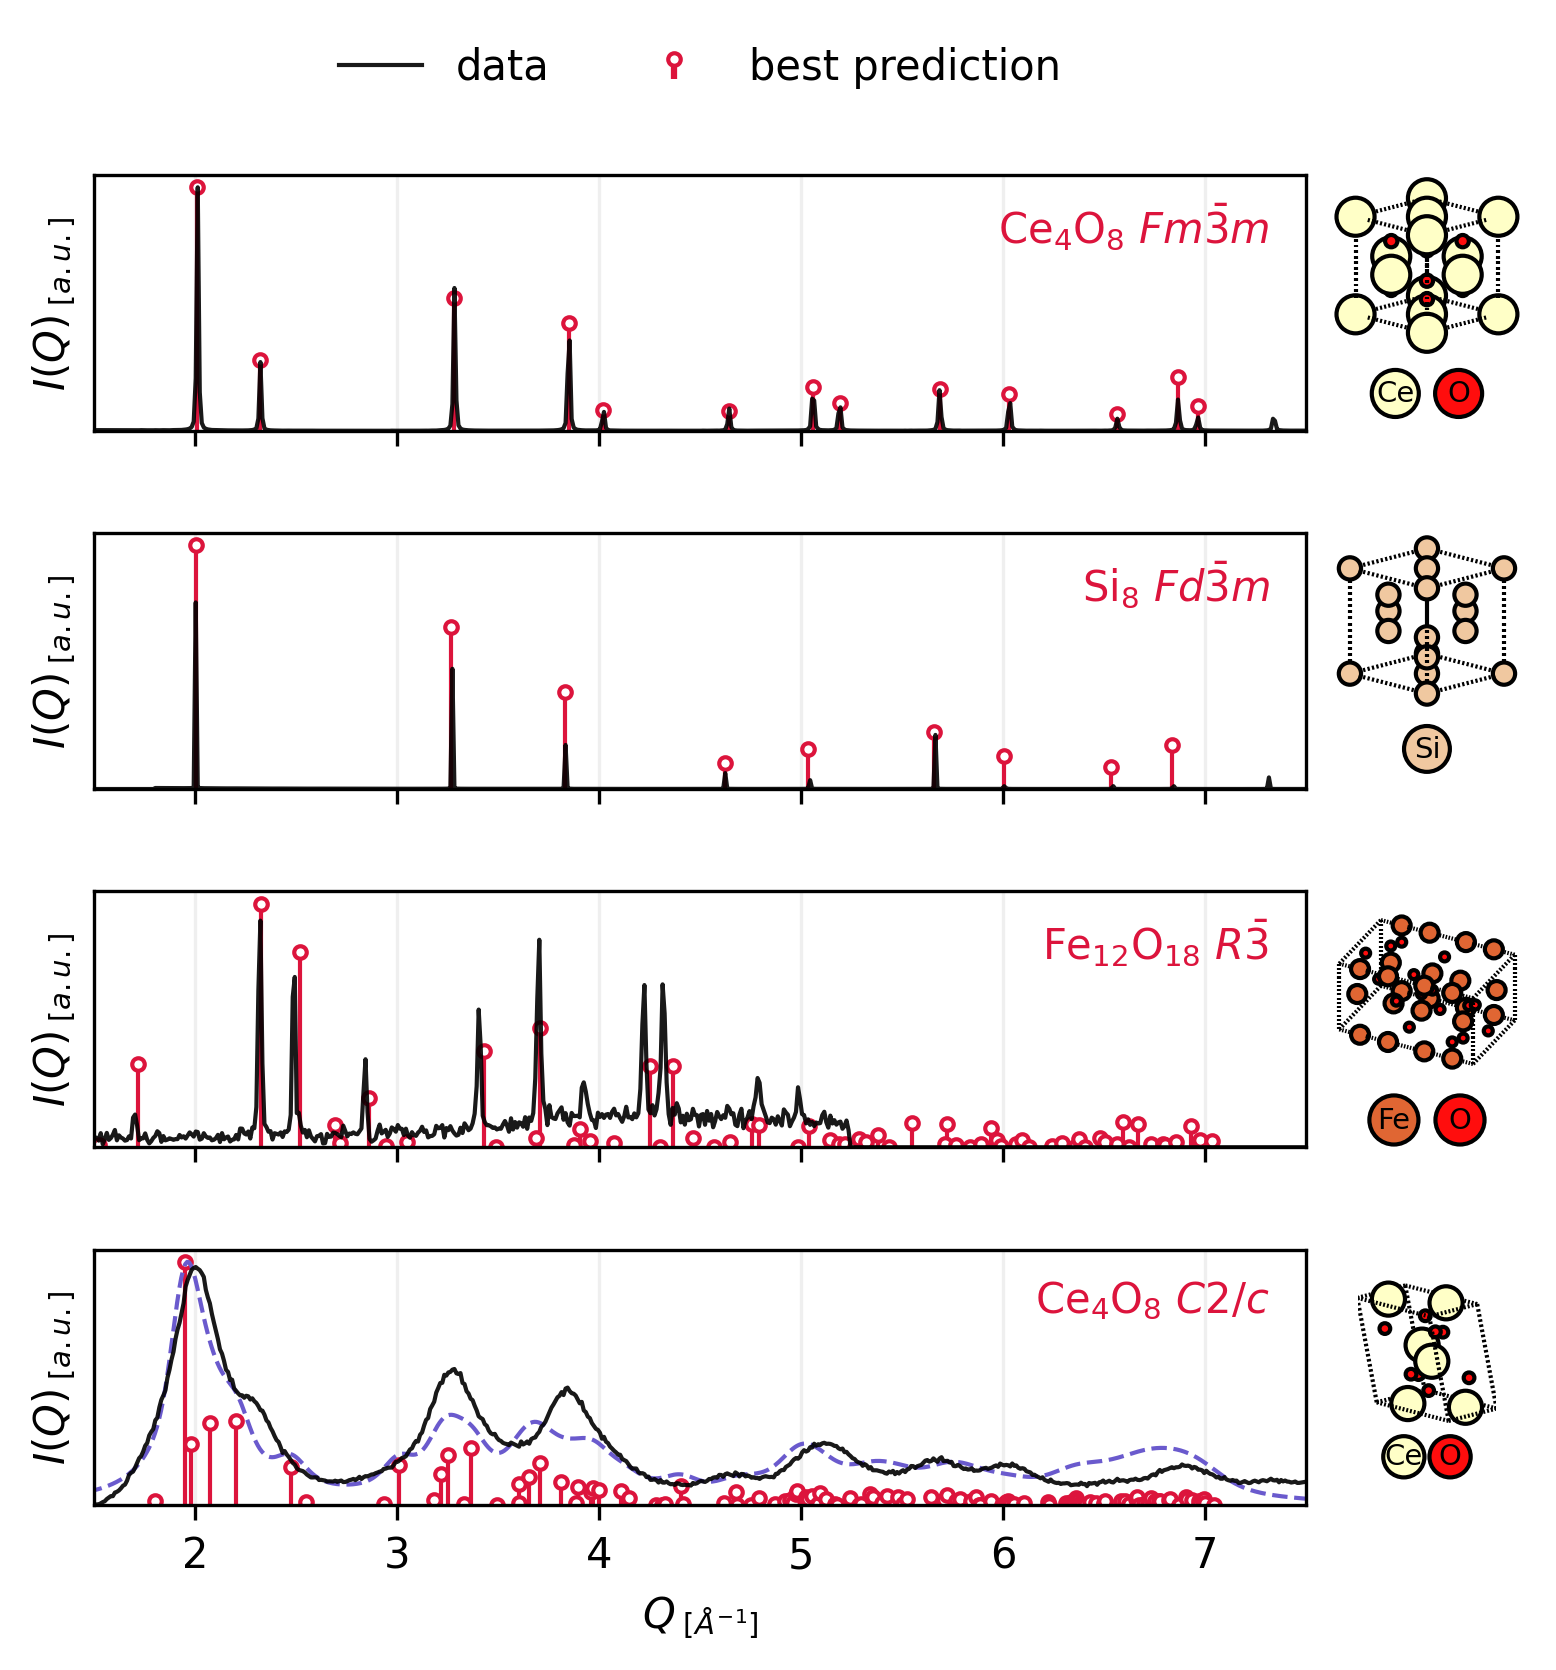

In [15]:
rows = [
    {
        'q':                CeO2_q,
        'iq':               CeO2_iq,
        'q_disc':           CeO2_q_disc,
        'iq_disc':          CeO2_iq_disc,
        'formula_latex':    CeO2_formula_latex,
        'spacegroup_latex': CeO2_spacegroup_latex,
        'structure':        CeO2_struc,
        'label':            'best prediction',
        # "title":            "PXRD of CeO₂",
    },
    {
        'q':                Si_q,
        'iq':               Si_iq,
        'q_disc':           Si_q_disc,
        'iq_disc':          Si_iq_disc,
        'formula_latex':    Si_formula_latex,
        'spacegroup_latex': Si_spacegroup_latex,
        'structure':        Si_struc,
        # "title":            "PXRD of CeO₂",
    },
    {
        'q':                Fe2O3_q,
        'iq':               Fe2O3_iq,
        'q_disc':           Fe2O3_q_disc,
        'iq_disc':          Fe2O3_iq_disc,
        'formula_latex':    Fe2O3_formula_latex,
        'spacegroup_latex': Fe2O3_spacegroup_latex,
        'structure':        Fe2O3_struc,
        'view':             {'zoom': 1.2}
    },
    {
        'q':                CeO2_particles_q,
        'iq':               CeO2_particles_iq,
        'q_disc':           CeO2_particles_q_disc,
        'iq_disc':          CeO2_particles_iq_disc,
        'formula_latex':    CeO2_particles_formula_latex,
        'spacegroup_latex': CeO2_particles_spacegroup_latex,
        'structure':        CeO2_particles_struc,
        'particles_pred':   (CeO2_particles_q_pred,
                             CeO2_particles_iq_pred,
                             r'$\tau = 10$Å'),
        'view':             {'zoom': 1.2, 'dy': 0.5}
    },
]

# ---------------------------
# Generate and save the figure
plot_pxrd_structures(
    rows,
    title_fontsize=7,
    hspace=0.4,
    wspace=-0.1,
    bbox_legend=(0.5,1.65)
)


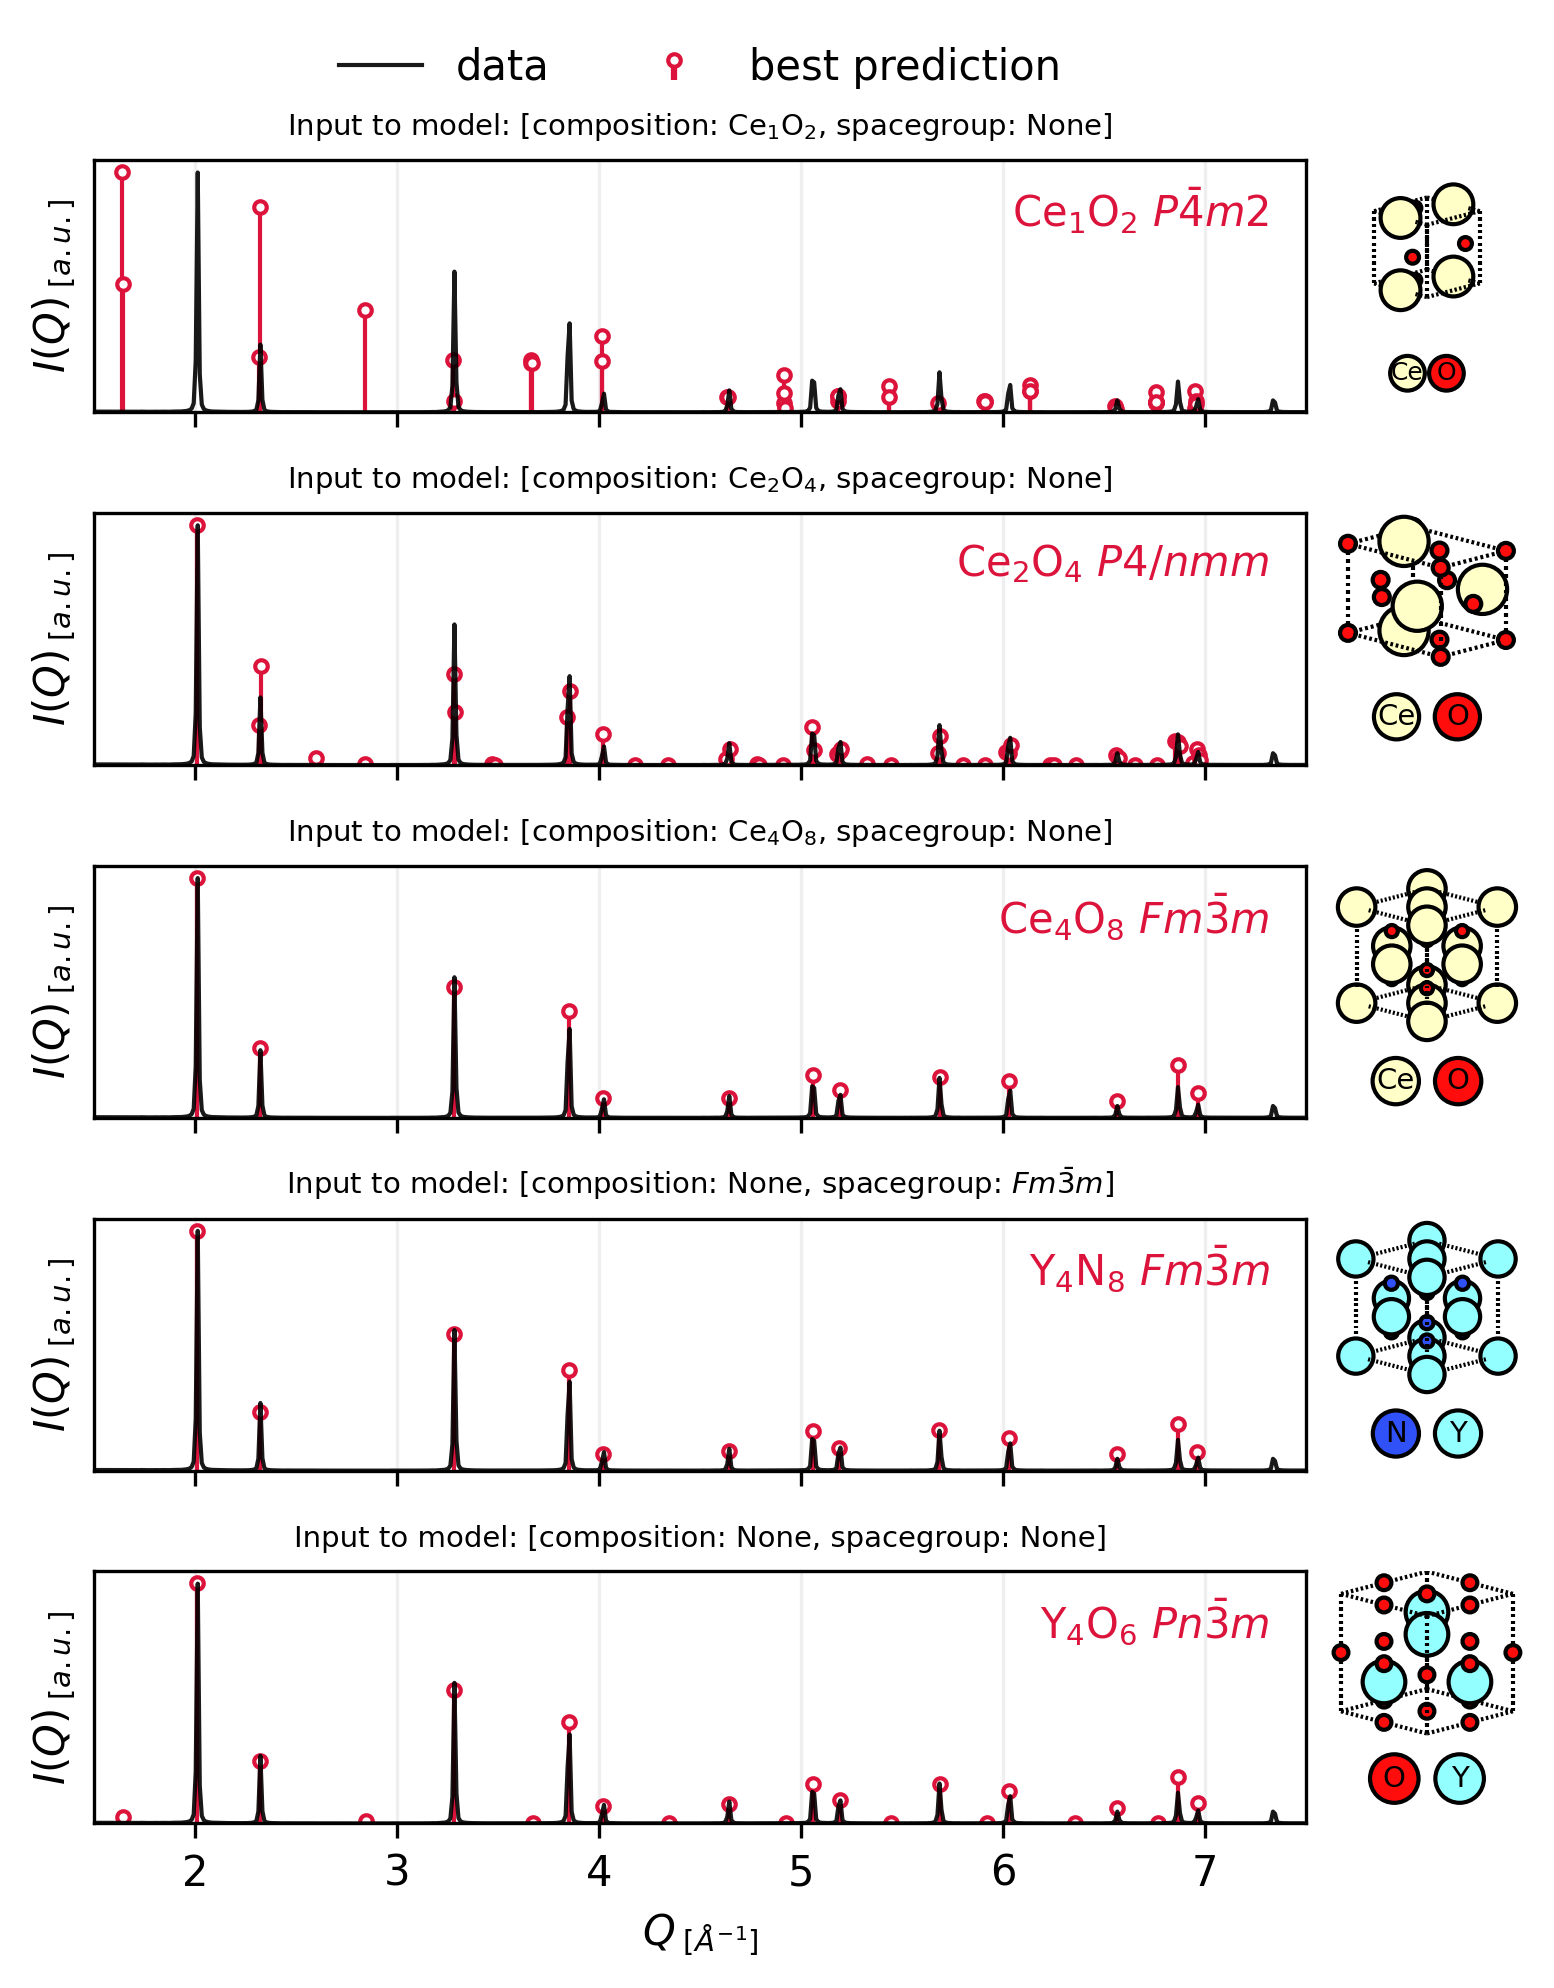

In [11]:
import pickle
import numpy as np

# Placeholder imports; replace with your actual functions
# from your_module import (
#     extract_space_group_symbol,
#     extract_formula_nonreduced,
#     format_formula_latex,
#     convert_space_group_to_latex,
#     plot_pxrd_structures
# )

pkl_path = "crystalline_CeO2.pkl"

# Per-key config: atoms_radius & atoms_label_size are optional
key_config_map = {
    "crystalline_CeO2_BM31_protocol_Ce1O2": {
        "title": r"Input to model: [composition: Ce$_1$O$_2$, spacegroup: None]",
        "atoms_radius": 60,
        "atoms_label_size": 6,
        "zoom": 1.2,
    },
    "crystalline_CeO2_BM31_protocol_Ce2O4": {
        "title": r"Input to model: [composition: Ce$_2$O$_4$, spacegroup: None]"
    },
    "crystalline_CeO2_BM31_protocol_Ce4O8": {
        "title": r"Input to model: [composition: Ce$_4$O$_8$, spacegroup: None]",
    },
    "crystalline_CeO2_BM31_protocol_Fm-3m": {
        "title": r"Input to model: [composition: None, spacegroup: $Fm\bar{3}m$]",
    },
    "crystalline_CeO2_BM31_protocol_none": {
        "title": r"Input to model: [composition: None, spacegroup: None]"
    },
}

rows = []
with open(pkl_path, "rb") as f:
    loaded = pickle.load(f)

for key, cfg in key_config_map.items():
    data = loaded[key]

    # extract experimental PXRD
    q       = data["exp_q"]
    iq      = data["exp_i"]
    q_disc  = np.array(data["pxrd"]["q_disc"][0])
    iq_disc = np.array(data["pxrd"]["iq_disc"][0]) / 100

    # extract structure and labels
    struct     = data["result"]["struct"]
    cif_str    = data["result"]["cif_str"]
    sg_symbol  = extract_space_group_symbol(cif_str)
    formula_rd = "".join(extract_formula_nonreduced(cif_str).split())

    row = {
        "q":                q,
        "iq":               iq,
        "q_disc":           q_disc,
        "iq_disc":          iq_disc,
        "structure":        struct,
        "formula_latex":    format_formula_latex(formula_rd),
        "spacegroup_latex": convert_space_group_to_latex(sg_symbol),
        "title":            cfg["title"]
    }

    # merge optional atom settings
    if "atoms_radius" in cfg:
        row["atoms_radius"] = cfg["atoms_radius"]
    if "atoms_label_size" in cfg:
        row["atoms_label_size"] = cfg["atoms_label_size"]
    if "zoom" in cfg:
        row["view"] = {}
        row["view"]["zoom"] = cfg["zoom"]

    rows.append(row)

# Now plot using defaults when atoms_* keys are missing
plot_pxrd_structures(
    rows,
    output_filename="experimental_data_crystalline_CeO2.png",
    title_fontsize=7,
    title_struc_fontsize=7,
    hspace=0.4,
    wspace=-0.1,
    bbox_legend=(0.5, 1.6)
)


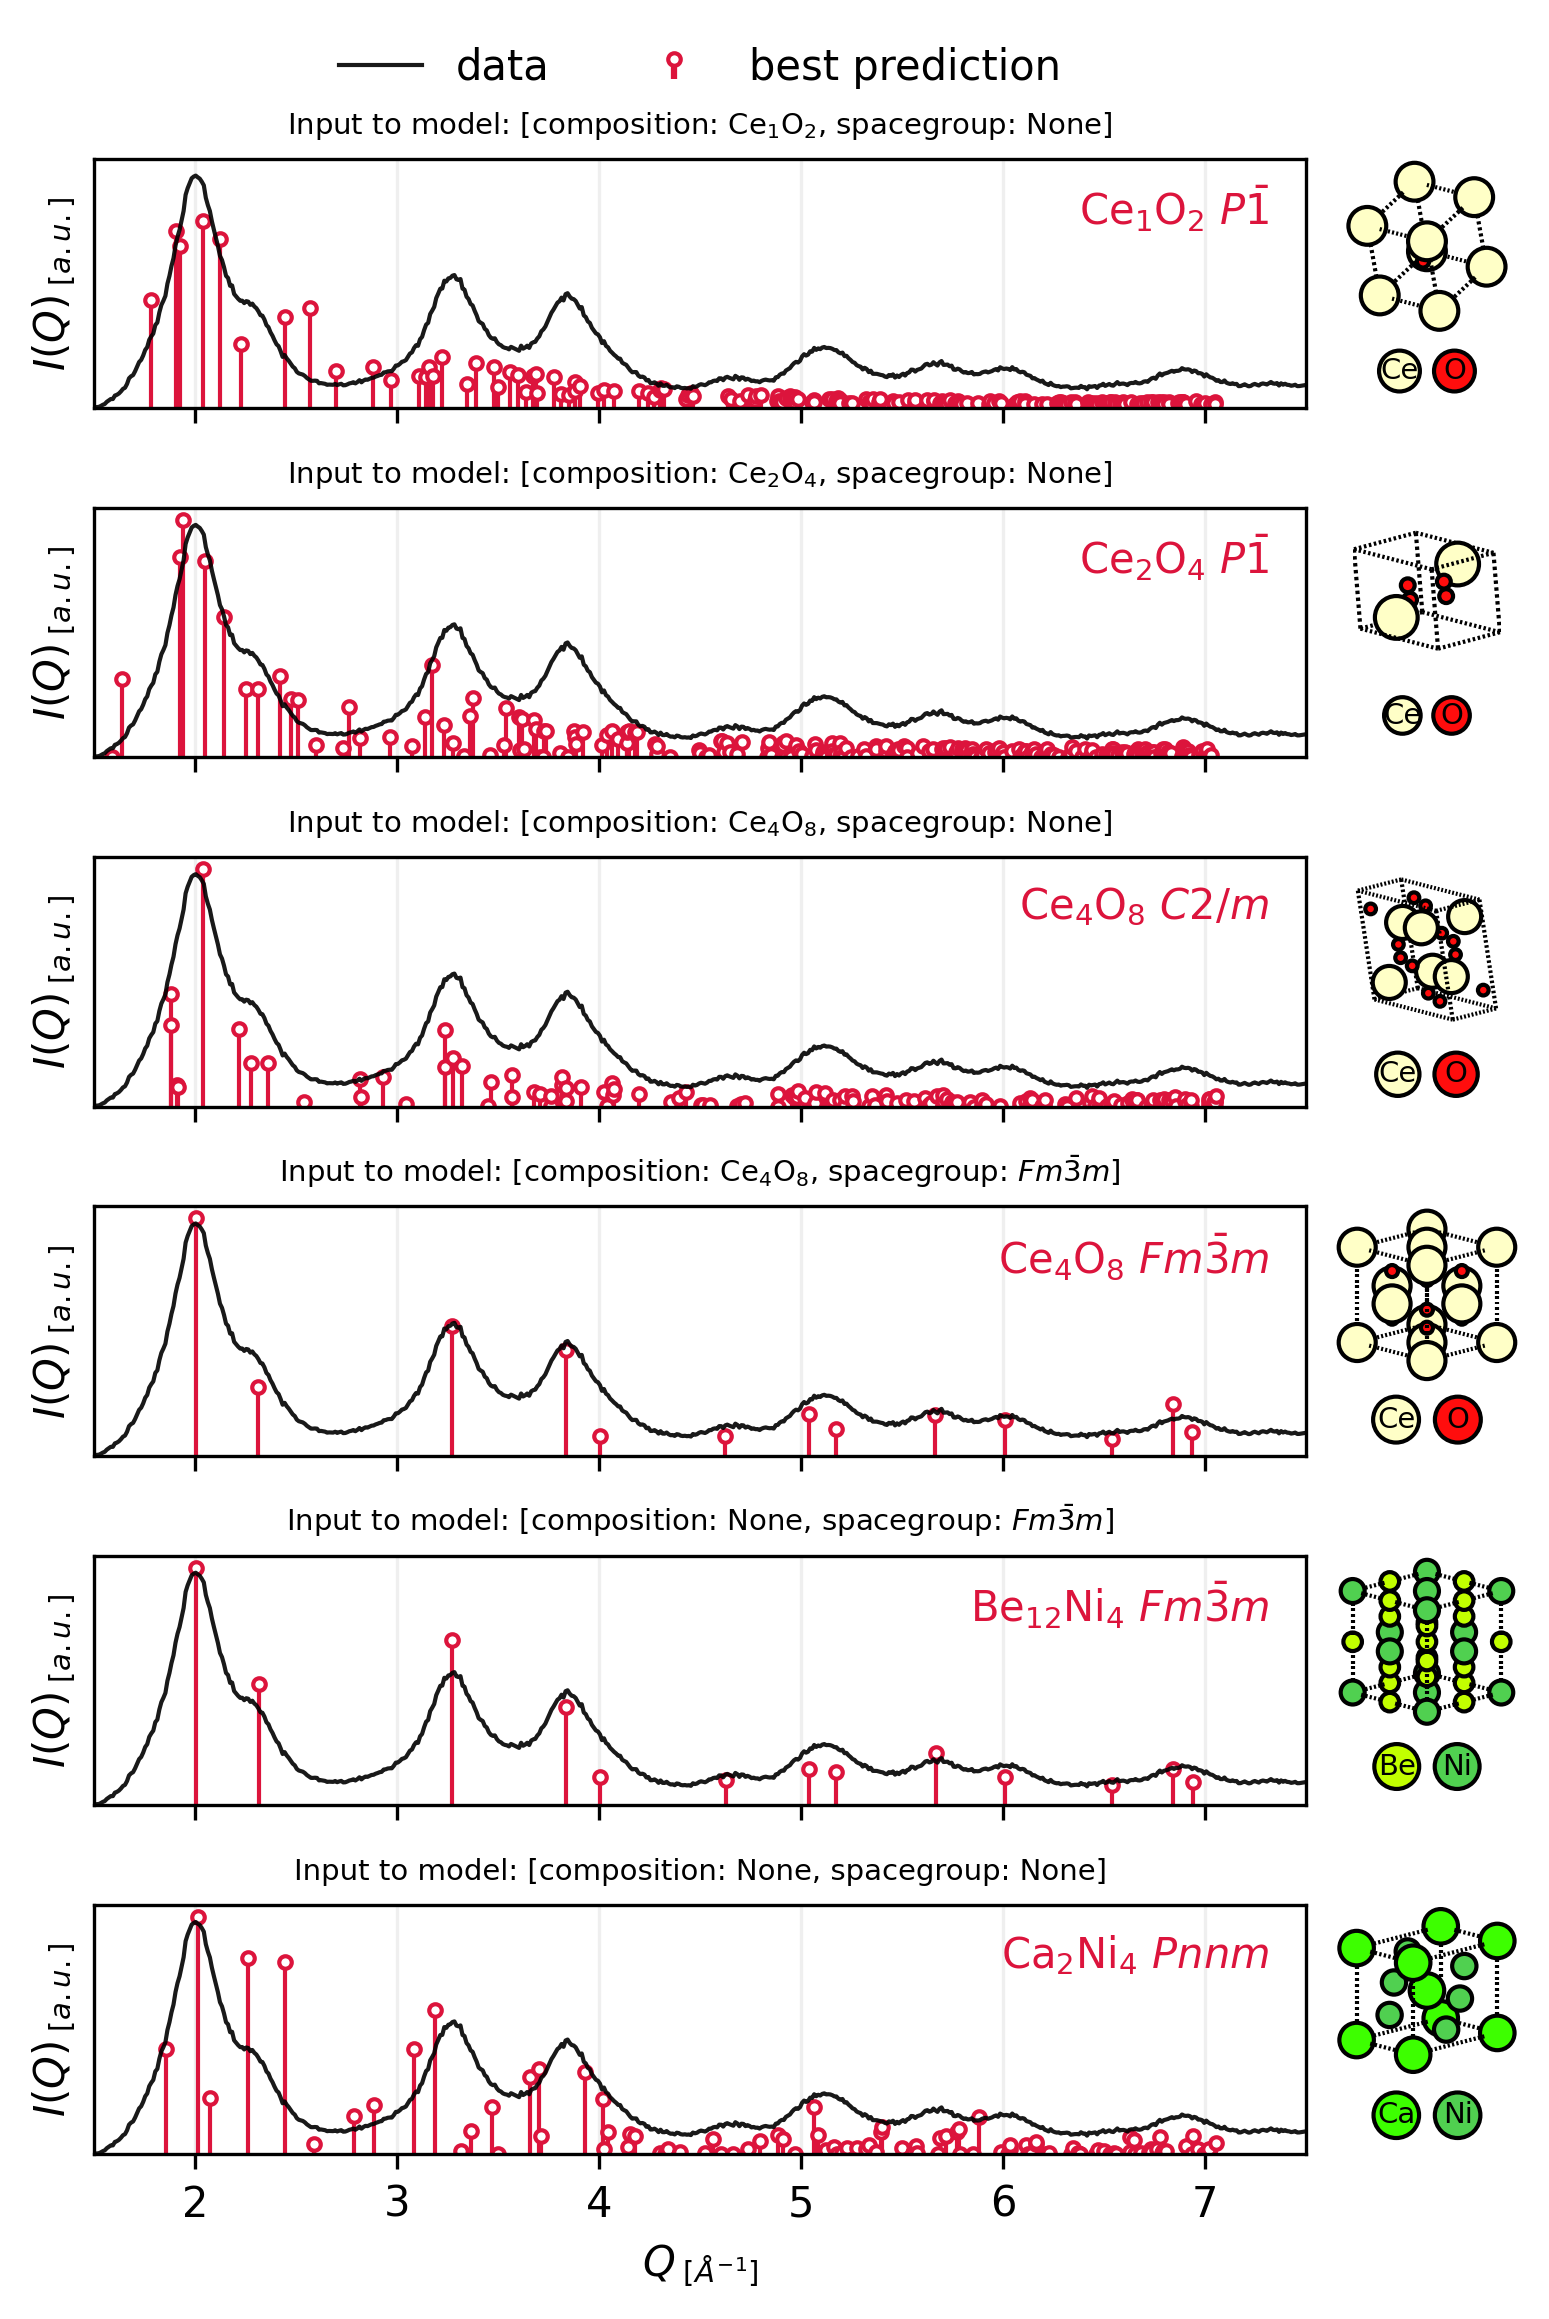

In [12]:
import pickle
import numpy as np

pkl_path = "particles_CeO2.pkl"

# Per-key config: atoms_radius & atoms_label_size are optional
key_config_map = {
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Ce1O2": {
        "title": r"Input to model: [composition: Ce$_1$O$_2$, spacegroup: None]",
    },
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Ce2O4": {
        "title": r"Input to model: [composition: Ce$_2$O$_4$, spacegroup: None]",
        "zoom": 1.35,
    },
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Ce4O8": {
        "title": r"Input to model: [composition: Ce$_4$O$_8$, spacegroup: None]",
        "zoom": 1.35,
    },
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Ce4O8_Fm-3m": {
        "title": r"Input to model: [composition: Ce$_4$O$_8$, spacegroup: $Fm\bar{3}m$]",
    },
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_Fm-3m": {
        "title": r"Input to model: [composition: None, spacegroup: $Fm\bar{3}m$]",
    },
    "Hydrolyse_ID5_20min_3-56_boro_0p8_protocol_none": {
        "title": r"Input to model: [composition: None, spacegroup: None]"
    },
}

rows = []
with open(pkl_path, "rb") as f:
    loaded = pickle.load(f)

for key, cfg in key_config_map.items():
    data = loaded[key]

    # extract experimental PXRD
    q       = data["exp_q"]
    iq      = data["exp_i"]
    q_disc  = np.array(data["pxrd"]["q_disc"][0])
    iq_disc = np.array(data["pxrd"]["iq_disc"][0]) / 100

    # extract structure and labels
    struct     = data["result"]["struct"]
    cif_str    = data["result"]["cif_str"]
    sg_symbol  = extract_space_group_symbol(cif_str)
    formula_rd = "".join(extract_formula_nonreduced(cif_str).split())

    row = {
        "q":                q,
        "iq":               iq,
        "q_disc":           q_disc,
        "iq_disc":          iq_disc,
        "structure":        struct,
        "formula_latex":    format_formula_latex(formula_rd),
        "spacegroup_latex": convert_space_group_to_latex(sg_symbol),
        "title":            cfg["title"],
    }

    # merge optional atom settings
    if "atoms_radius" in cfg:
        row["atoms_radius"] = cfg["atoms_radius"]
    if "atoms_label_size" in cfg:
        row["atoms_label_size"] = cfg["atoms_label_size"]
    if "zoom" in cfg:
        row["view"] = {}
        row["view"]["zoom"] = cfg["zoom"]

    rows.append(row)

# Now plot using defaults when atoms_* keys are missing
plot_pxrd_structures(
    rows,
    output_filename="experimental_data_particles_CeO2.png",
    title_fontsize=7,
    title_struc_fontsize=7,
    hspace=0.4,
    wspace=-0.1,
    bbox_legend=(0.5, 1.6)
)


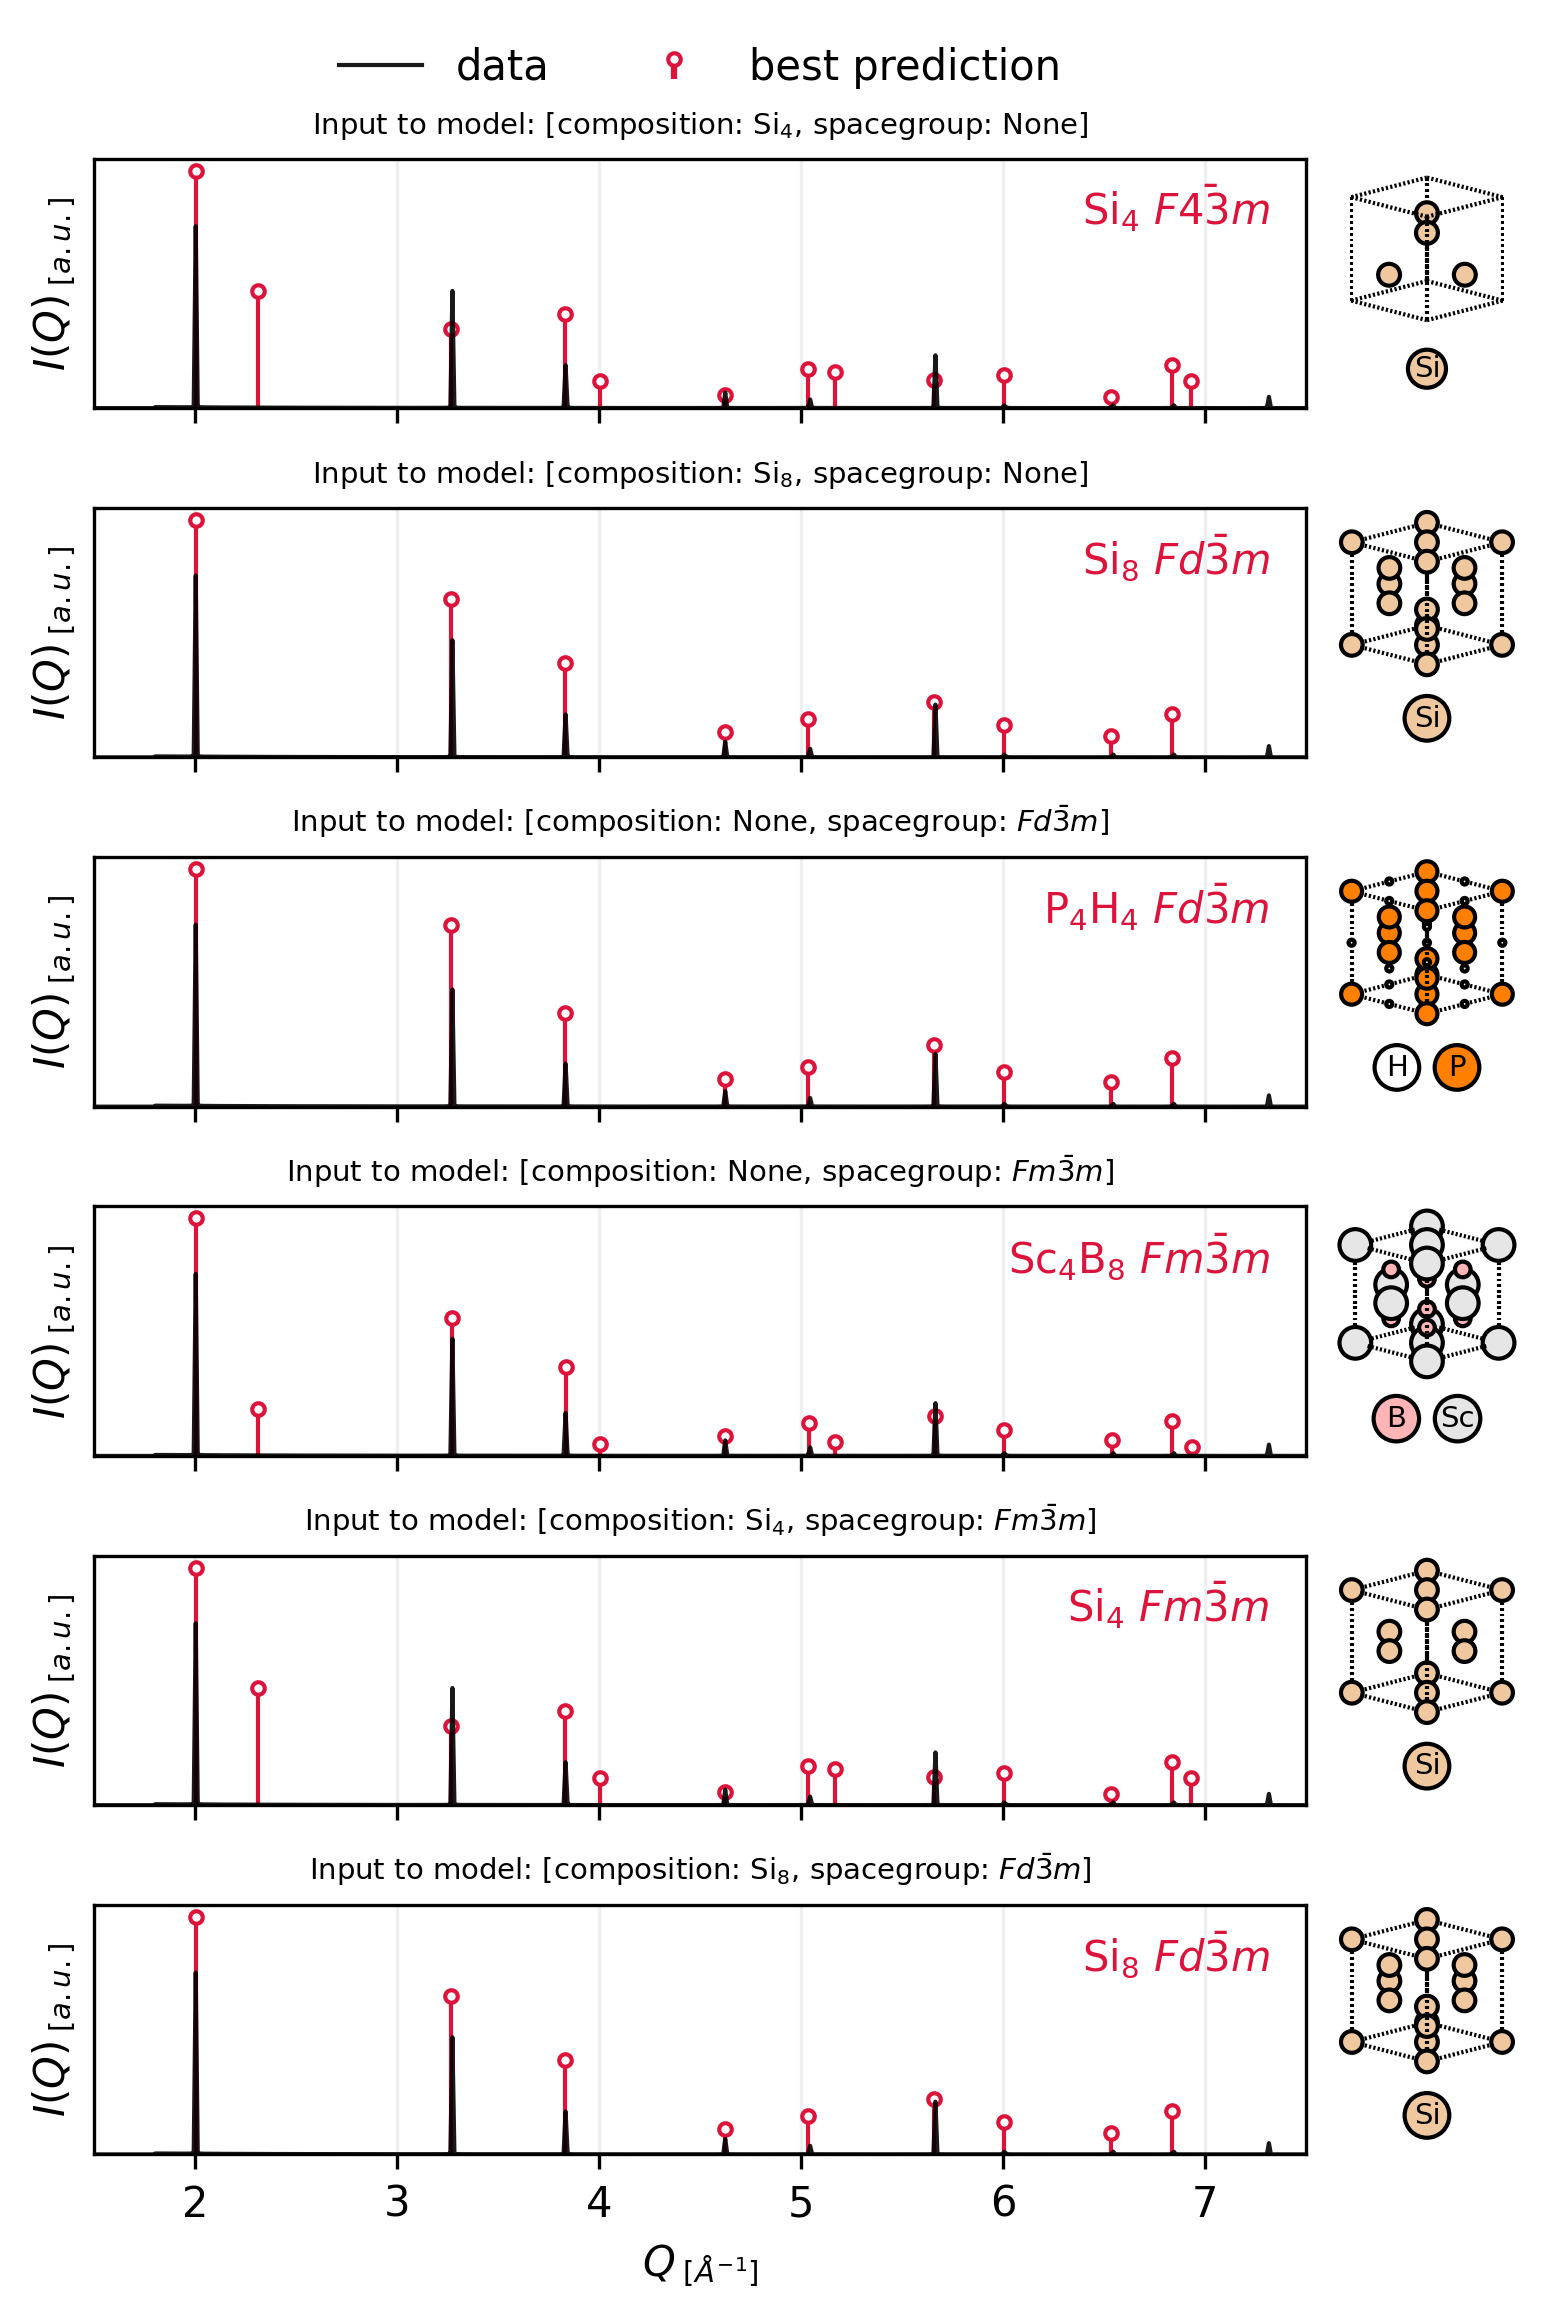

In [13]:
import pickle
import numpy as np

pkl_path = "crystalline_Si.pkl"

# Per-key config: atoms_radius & atoms_label_size are optional
key_config_map = {
    "Si_Mythen_protocol_Si4": {
        "title": r"Input to model: [composition: Si$_4$, spacegroup: None]",
        "zoom": 1.5,
    },
    "Si_Mythen_protocol_Si8": {
        "title": r"Input to model: [composition: Si$_8$, spacegroup: None]",
        # "zoom": 1.5,
    },
    "Si_Mythen_protocol_Fd-3m": {
        "title": r"Input to model: [composition: None, spacegroup: $Fd\bar{3}m$]",
        # "zoom": 1.5,
    },
    "Si_Mythen_protocol_Fm-3m": {
        "title": r"Input to model: [composition: None, spacegroup: $Fm\bar{3}m$]",
        # "zoom": 1.5,
    },
    "Si_Mythen_protocol_Si4_Fm-3m": {
        "title": r"Input to model: [composition: Si$_4$, spacegroup: $Fm\bar{3}m$]",
        # "zoom": 1.5,
    },
    "Si_Mythen_protocol_Si8_Fd-3m": {
        "title": r"Input to model: [composition: Si$_8$, spacegroup: $Fd\bar{3}m$]",
        # "zoom": 1.5,
    },
}

rows = []
with open(pkl_path, "rb") as f:
    loaded = pickle.load(f)

for key, cfg in key_config_map.items():
    data = loaded[key]

    # extract experimental PXRD
    q       = data["exp_q"]
    iq      = data["exp_i"]
    q_disc  = np.array(data["pxrd"]["q_disc"][0])
    iq_disc = np.array(data["pxrd"]["iq_disc"][0]) / 100

    # extract structure and labels
    struct     = data["result"]["struct"]
    cif_str    = data["result"]["cif_str"]
    sg_symbol  = extract_space_group_symbol(cif_str)
    formula_rd = "".join(extract_formula_nonreduced(cif_str).split())

    row = {
        "q":                q,
        "iq":               iq,
        "q_disc":           q_disc,
        "iq_disc":          iq_disc,
        "structure":        struct,
        "formula_latex":    format_formula_latex(formula_rd),
        "spacegroup_latex": convert_space_group_to_latex(sg_symbol),
        "title":            cfg["title"],
    }

    # merge optional atom settings
    if "atoms_radius" in cfg:
        row["atoms_radius"] = cfg["atoms_radius"]
    if "atoms_label_size" in cfg:
        row["atoms_label_size"] = cfg["atoms_label_size"]
    if "zoom" in cfg:
        row["view"] = {}
        row["view"]["zoom"] = cfg["zoom"]

    rows.append(row)

# Now plot using defaults when atoms_* keys are missing
plot_pxrd_structures(
    rows,
    output_filename="experimental_data_crystalline_Si.png",
    title_fontsize=7,
    title_struc_fontsize=7,
    hspace=0.4,
    wspace=-0.1,
    bbox_legend=(0.5, 1.6)
)


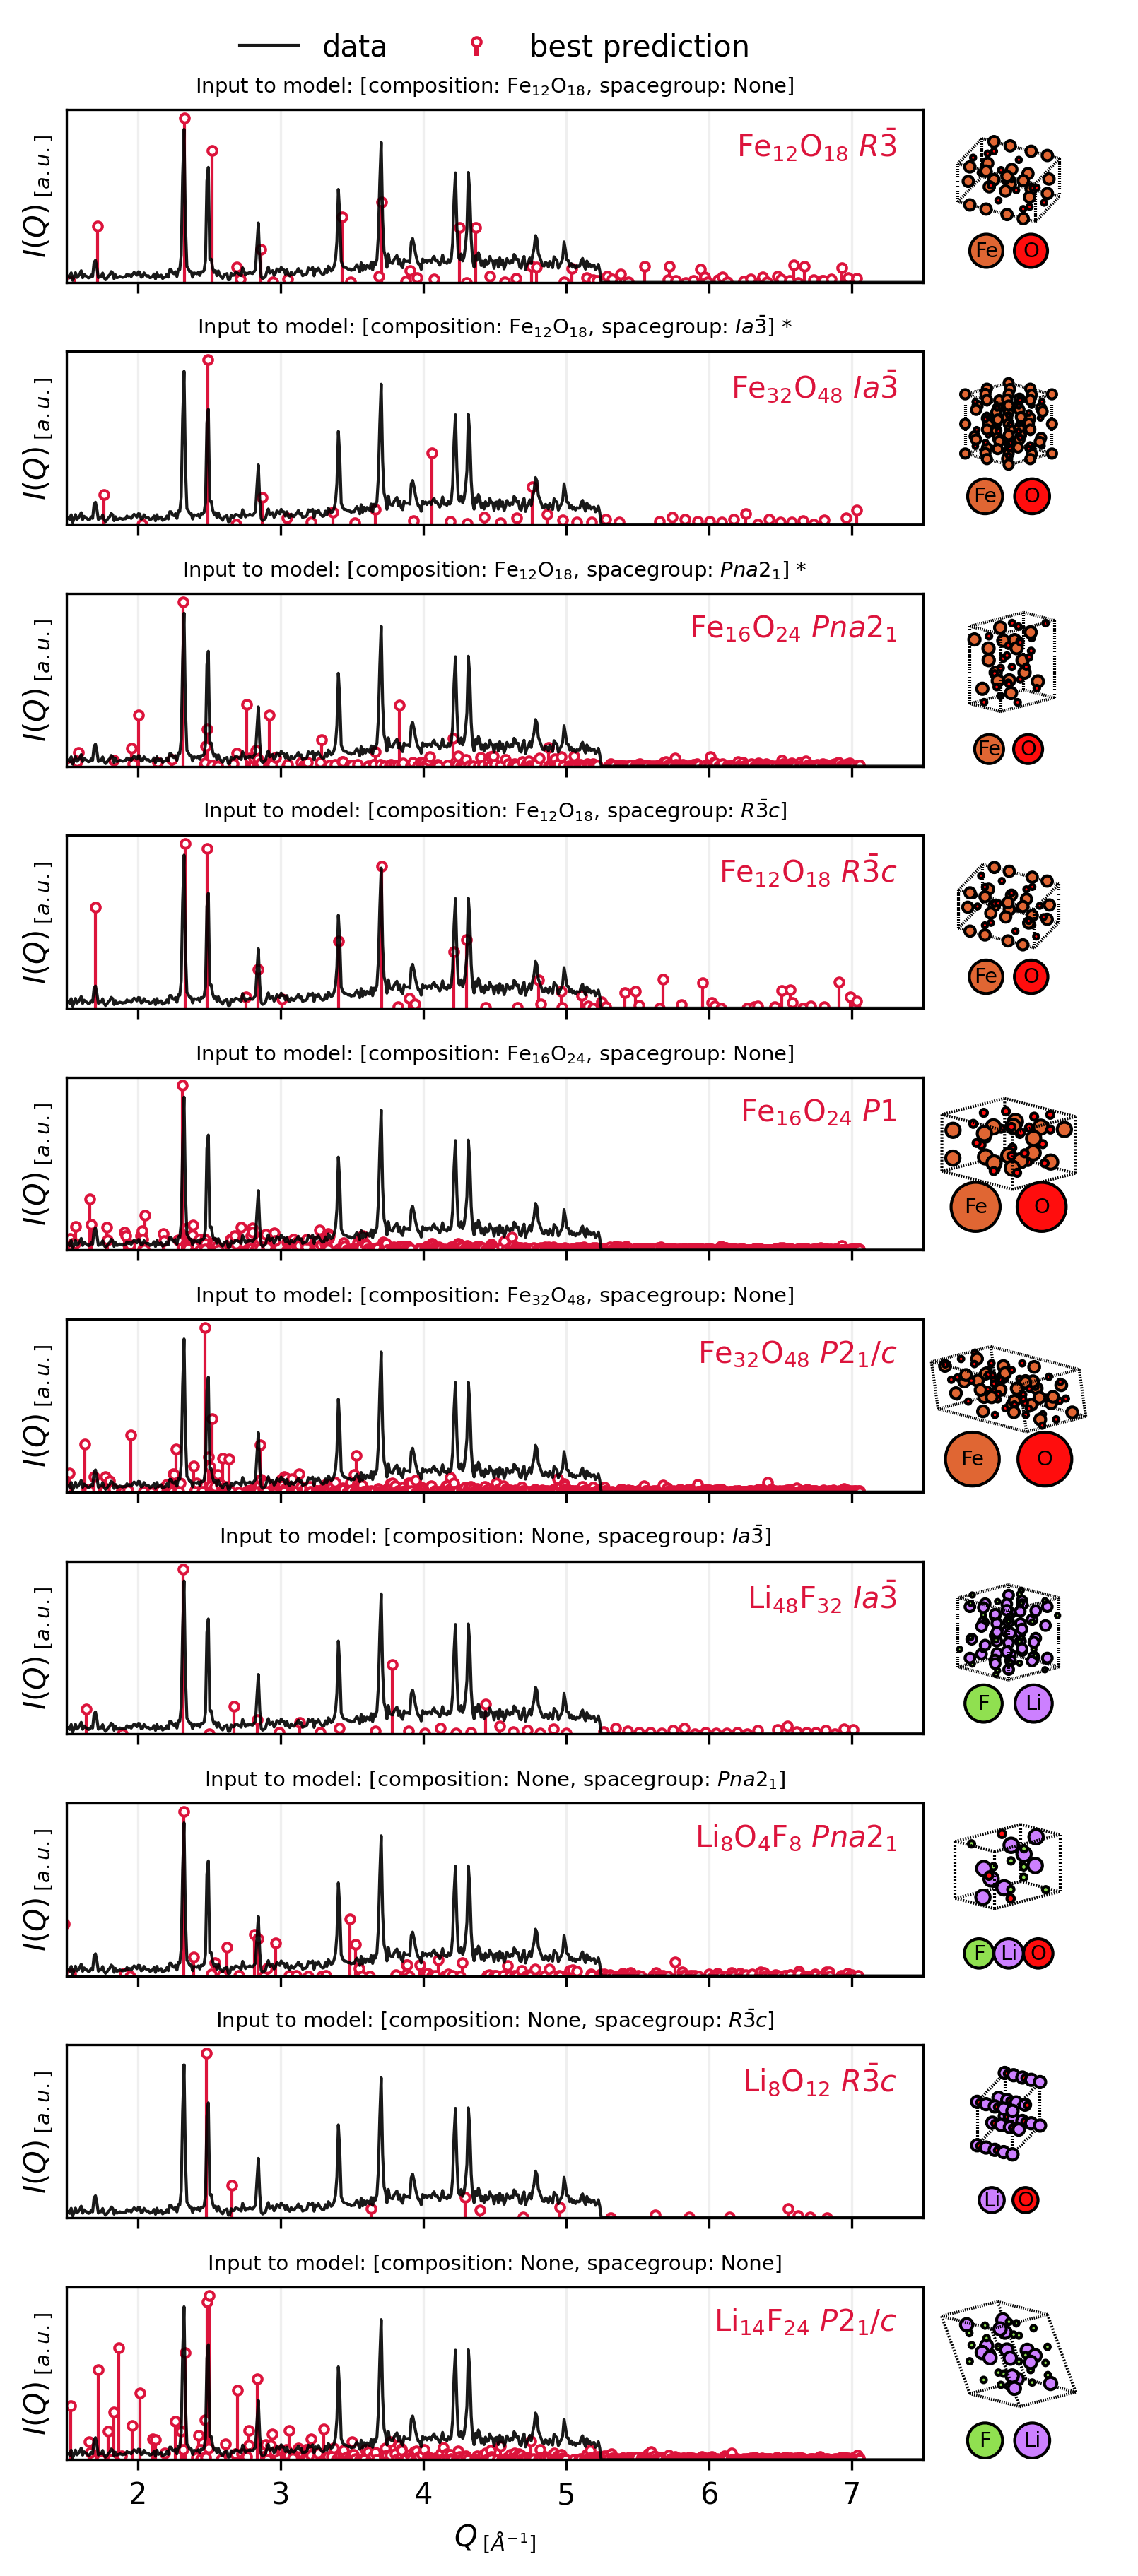

In [14]:
import pickle
import numpy as np

pkl_path = "crystalline_Fe2O3.pkl"

# Per-key config: atoms_radius & atoms_label_size are optional
key_config_map = {
    "AFS012d_a850C_protocol_Fe12O18": {
        "title": r"Input to model: [composition: Fe$_{12}$O$_{18}$, spacegroup: None]",
        "zoom": 1.4,
        "atom_offset_y": 2.0,
    },
    "AFS012d_a850C_protocol_Fe12O18_Ia-3": {
        "title": r"Input to model: [composition: Fe$_{12}$O$_{18}$, spacegroup: $Ia\bar{3}$] *",
        "zoom": 1.4,
        "atom_offset_y": 2.0,
    },
    "AFS012d_a850C_protocol_Fe12O18_Pna2_1": {
        "title": r"Input to model: [composition: Fe$_{12}$O$_{18}$, spacegroup: $Pna2_1$] *",
        "zoom": 1.4,
    },
    "AFS012d_a850C_protocol_Fe12O18_R-3c": {
        "title": r"Input to model: [composition: Fe$_{12}$O$_{18}$, spacegroup: $R\bar{3}c$]",
        "zoom": 1.4,
        "atom_offset_y": 2.0,
    },
    "AFS012d_a850C_protocol_Fe16O24": {
        "title": r"Input to model: [composition: Fe$_{16}$O$_{24}$, spacegroup: None]",
        "zoom": 1.5,
        "atom_offset_y": 2.0,
    },
    "AFS012d_a850C_protocol_Fe32O48": {
        "title": r"Input to model: [composition: Fe$_{32}$O$_{48}$, spacegroup: None]",
        "zoom": 1.5,
        "atom_offset_y": 2.0,
    },
    "AFS012d_a850C_protocol_Ia-3": {
        "title": r"Input to model: [composition: None, spacegroup: $Ia\bar{3}$]",
        "zoom": 1.4,
        "atom_offset_y": 2.0,
    },
    "AFS012d_a850C_protocol_Pna2_1": {
        "title": r"Input to model: [composition: None, spacegroup: $Pna2_1$]",
        "zoom": 1.4,
    },
    "AFS012d_a850C_protocol_R-3c": {
        "title": r"Input to model: [composition: None, spacegroup: $R\bar{3}c$]",
        "zoom": 1.3,
    },
    "AFS012d_a850C_protocol_none": {
        "title": r"Input to model: [composition: None, spacegroup: None]",
        "zoom": 1.4,
    },
}

rows = []
with open(pkl_path, "rb") as f:
    loaded = pickle.load(f)

for key, cfg in key_config_map.items():
    data = loaded[key]

    # extract experimental PXRD
    q       = data["exp_q"]
    iq      = data["exp_i"]
    q_disc  = np.array(data["pxrd"]["q_disc"][0])
    iq_disc = np.array(data["pxrd"]["iq_disc"][0]) / 100

    # extract structure and labels
    struct     = data["result"]["struct"]
    cif_str    = data["result"]["cif_str"]
    sg_symbol  = extract_space_group_symbol(cif_str)
    formula_rd = "".join(extract_formula_nonreduced(cif_str).split())

    row = {
        "q":                q,
        "iq":               iq,
        "q_disc":           q_disc,
        "iq_disc":          iq_disc,
        "structure":        struct,
        "formula_latex":    format_formula_latex(formula_rd),
        "spacegroup_latex": convert_space_group_to_latex(sg_symbol),
        "title":            cfg["title"],
        "view": {}
    }

    # merge optional atom settings
    if "atoms_radius" in cfg:
        row["atoms_radius"] = cfg["atoms_radius"]
    if "atoms_label_size" in cfg:
        row["atoms_label_size"] = cfg["atoms_label_size"]
    if "zoom" in cfg:
        row["view"]["zoom"] = cfg["zoom"]
    if "atom_offset_y" in cfg:
        row["view"]["atom_offset_y"] = cfg["atom_offset_y"]

    rows.append(row)

# Now plot using defaults when atoms_* keys are missing
plot_pxrd_structures(
    rows,
    output_filename="experimental_data_crystalline_Fe2O3.png",
    title_fontsize=7,
    title_struc_fontsize=7,
    hspace=0.4,
    wspace=-0.1,
    bbox_legend=(0.5, 1.6)
)
